# Self-Driving Car Engineer Nanodegree

## Project 2: Build a Traffic Sign Recognition Classifier by Toan Luong

Updated: 2-26-2018

Train a convolutional neural network to classify traffic signs from the German Traffic Sign Dataset.

## 1. Load the data and visualize all labels

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
# Visualizations will be shown in the notebook.
%matplotlib inline

In [3]:
training_file = "dataset/train.p"
validation_file = "dataset/valid.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = (X_train.shape[1:])
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


All training/valid/test files are already packaged in pickle files. After unpacking, the number of training examples are 3 times more than the testing examples. We save more than 4,410 images for validation and tuning the hyperparameters.

Image size is (32, 32, 3) meaning the image width x height is 32 x 32. And 3 RGB channels.

We have **43** unique traffic sign labels as given from the `signnames.csv` file. As shown below. Notice images have varied degree of brightness and contrasts which we have to fix.

Index 0. Sign name: Speed limit (20km/h). Number of signs: 180


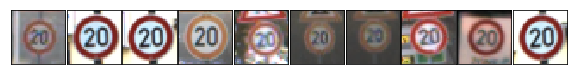

Index 1. Sign name: Speed limit (30km/h). Number of signs: 1980


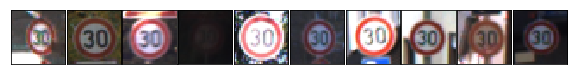

Index 2. Sign name: Speed limit (50km/h). Number of signs: 2010


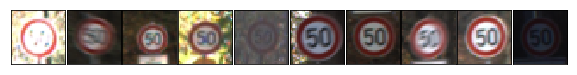

Index 3. Sign name: Speed limit (60km/h). Number of signs: 1260


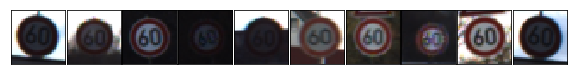

Index 4. Sign name: Speed limit (70km/h). Number of signs: 1770


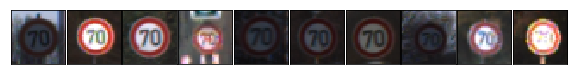

Index 5. Sign name: Speed limit (80km/h). Number of signs: 1650


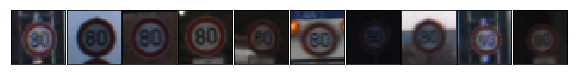

Index 6. Sign name: End of speed limit (80km/h). Number of signs: 360


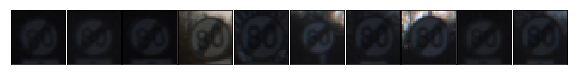

Index 7. Sign name: Speed limit (100km/h). Number of signs: 1290


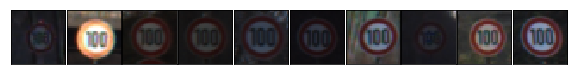

Index 8. Sign name: Speed limit (120km/h). Number of signs: 1260


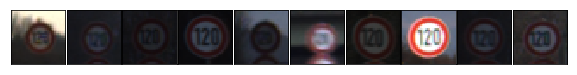

Index 9. Sign name: No passing. Number of signs: 1320


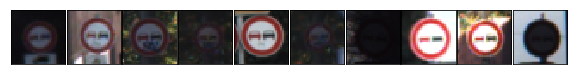

Index 10. Sign name: No passing for vehicles over 3.5 metric tons. Number of signs: 1800


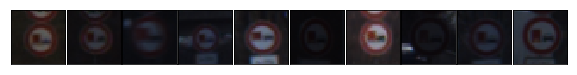

Index 11. Sign name: Right-of-way at the next intersection. Number of signs: 1170


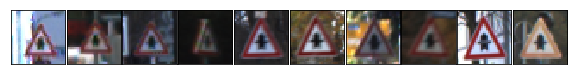

Index 12. Sign name: Priority road. Number of signs: 1890


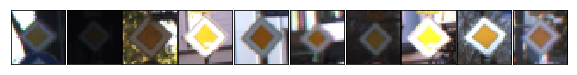

Index 13. Sign name: Yield. Number of signs: 1920


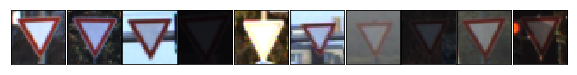

Index 14. Sign name: Stop. Number of signs: 690


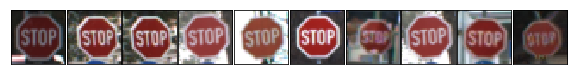

Index 15. Sign name: No vehicles. Number of signs: 540


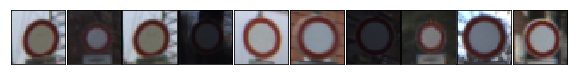

Index 16. Sign name: Vehicles over 3.5 metric tons prohibited. Number of signs: 360


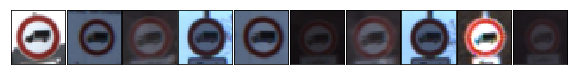

Index 17. Sign name: No entry. Number of signs: 990


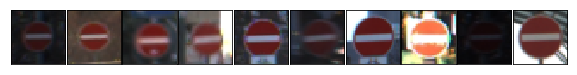

Index 18. Sign name: General caution. Number of signs: 1080


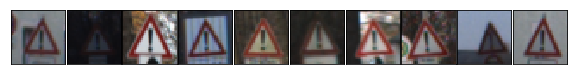

Index 19. Sign name: Dangerous curve to the left. Number of signs: 180


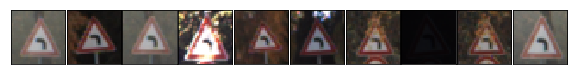

Index 20. Sign name: Dangerous curve to the right. Number of signs: 300


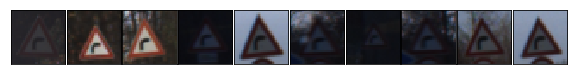

Index 21. Sign name: Double curve. Number of signs: 270


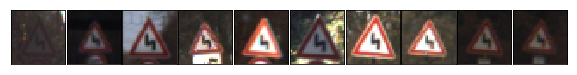

Index 22. Sign name: Bumpy road. Number of signs: 330


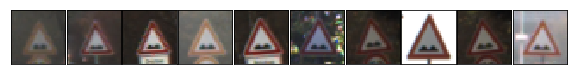

Index 23. Sign name: Slippery road. Number of signs: 450


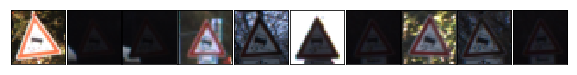

Index 24. Sign name: Road narrows on the right. Number of signs: 240


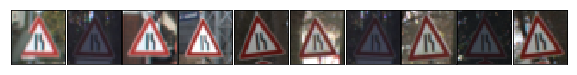

Index 25. Sign name: Road work. Number of signs: 1350


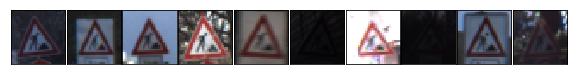

Index 26. Sign name: Traffic signals. Number of signs: 540


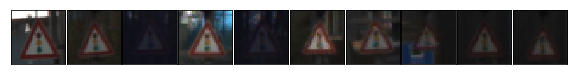

Index 27. Sign name: Pedestrians. Number of signs: 210


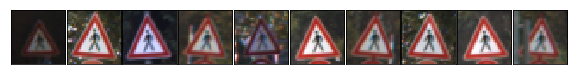

Index 28. Sign name: Children crossing. Number of signs: 480


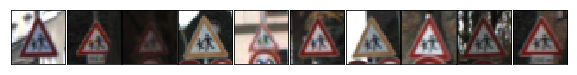

Index 29. Sign name: Bicycles crossing. Number of signs: 240


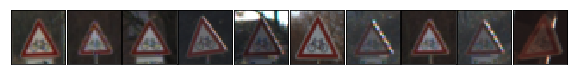

Index 30. Sign name: Beware of ice/snow. Number of signs: 390


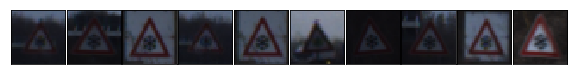

Index 31. Sign name: Wild animals crossing. Number of signs: 690


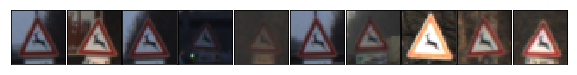

Index 32. Sign name: End of all speed and passing limits. Number of signs: 210


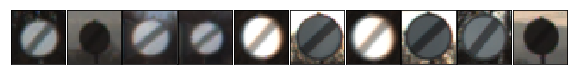

Index 33. Sign name: Turn right ahead. Number of signs: 599


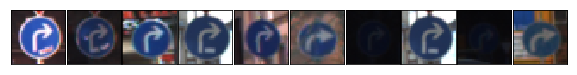

Index 34. Sign name: Turn left ahead. Number of signs: 360


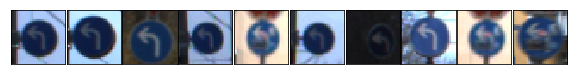

Index 35. Sign name: Ahead only. Number of signs: 1080


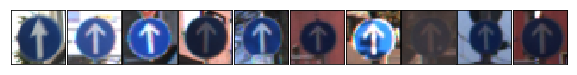

Index 36. Sign name: Go straight or right. Number of signs: 330


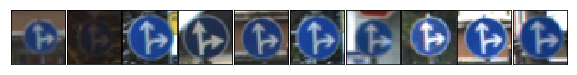

Index 37. Sign name: Go straight or left. Number of signs: 180


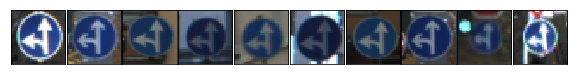

Index 38. Sign name: Keep right. Number of signs: 1860


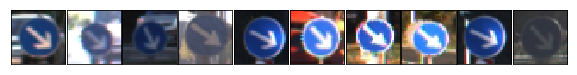

Index 39. Sign name: Keep left. Number of signs: 270


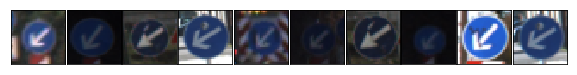

Index 40. Sign name: Roundabout mandatory. Number of signs: 300


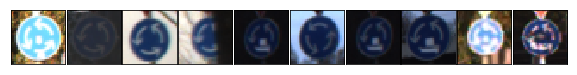

Index 41. Sign name: End of no passing. Number of signs: 210


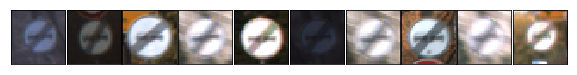

Index 42. Sign name: End of no passing by vehicles over 3.5 metric tons. Number of signs: 210


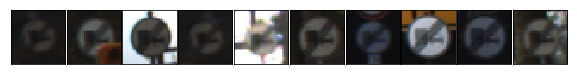

In [4]:
sign_names = list(pd.read_csv("dataset/signnames.csv")['SignName'])

import random

def display_images(Xd, yd, labels_names, num_display=10, squeeze=False, cmap=None):
    samples_per_class = np.bincount(yd)
    for i, label in enumerate(labels_names):
        print("Index {0}. Sign name: {1}. Number of signs: {2}".format(i, label, samples_per_class[i]))
        samples = random.sample(list(np.where(yd==i)[0]), num_display)
        fig = plt.figure(figsize=(num_display, 1))
        fig.subplots_adjust(hspace=0, wspace=0)
        for j, idx in enumerate(samples):
            img = Xd[idx]
            axis = fig.add_subplot(1, num_display, j+1, xticks=[], yticks=[])
            if squeeze and cmap:
                axis.imshow(img.squeeze(), cmap=cmap)
            else:
                axis.imshow(img)
        plt.show()

display_images(X_train, y_train, sign_names)

Let's plot the sample distribution among the 43 classes. As clearly shown, most classes are under-sampled with less than 1,000 training images. We can't perform training on this dataset because the model might fail to recognize traffic signs that have few training examples. 

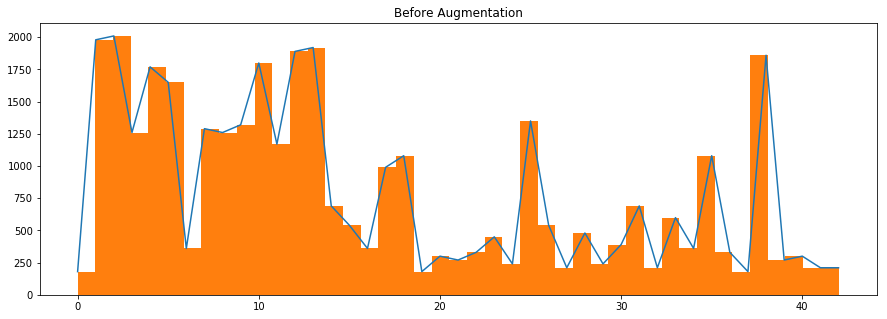

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(np.bincount(y_train))
plt.hist(y_train, bins=n_classes)
plt.title('Before Augmentation')
plt.show()

## 2. Data Augmentation

Our goal is to utilize image-transformation techniques to augment the datasets and balance the sampling distribution.

For the class `ImageEffect`, we have the following methods:
* `randomize()` will generate a random boolean arrays to select x tranformations out of 5 choices
* `translate()` will generate M-matrix based on x, y-shift and used `cv2.warpAffine()`
* `rotate()` will generate M-matrix in the `cv2.warpAffine()` from the output of `cv2.getRotationMatrix2D((x/2, y/2), rotate_degree, scale)`
* `blur()` will use `cv2.GaussianBlur()`
* `gamma()` will brighten up the image based on lookup table as `np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")` and `cv2.LUT(image, table)`. The formula is $[\frac{i}{255}^\frac{1}{\gamma} * 255]$

In [6]:
import cv2
from itertools import compress
class ImageEffect:
    """A combinations of image manipulation methods to augment dataset.
    
    The effects include: translation, rotation, shear, blur, gamma.
    Source: @eqbal, https://li8bot.wordpress.com/2014/07/21/opencvpythonpart3-geometric-transformations-2/
    
    Attributes:
        image: feed in the image that can be transformed
    """
    
    def randomize(self, image, show=False):
        """Randomize the effects on the input image
        """
        lottery = np.random.randint(0, 2, [5]).astype('bool')
        types = ["Translate", "Rotate", "Shear", "Blur", "Gamma"]
        
        if lottery[0]:
            image = self.translate(image)
        if lottery[1]:
            image = self.rotate(image)
        if lottery[2]:
            image = self.shear(image)
        if lottery[3]:
            image = self.blur(image)
        if lottery[4]:
            image = self.gamma(image)
            
        return list(compress(types, lottery)), image
    
    def translate(self, image, show=False):
        """Translate
        """
        y, x, channel = image.shape
        # Shift along the y-axis up to 30%. Shift along the x-axis up to 30%
        y_shift, x_shift = np.random.uniform(-0.3*y, 0.3*y), np.random.uniform(-0.3*x, 0.3*x)
        if show:
            print("y-axis:", y_shift, "x-axis:", x_shift)
        M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
        dst = cv2.warpAffine(image, M, (x, y))
        return dst
        
    def rotate(self, image, show=False, rotate_degree=90):
        """Rotate
        """
        y, x, channel = image.shape
        # Rotate it by 90 degrees anticlockwise. Scale factor = 1, similar to original
        # (x/2, y/2) : center of the rotation in the source image
        M = cv2.getRotationMatrix2D((x/2, y/2), rotate_degree, 1)
        if show:
            print(M)
        dst = cv2.warpAffine(image, M, (x, y))
        return dst
    
    def shear(self, image):
        """Shear. Keep parallel lines together.
        """
        y, x, channel = image.shape
        pts1 = np.float32([[5,5],[20,5],[5,20]])
        
        shear = np.random.randint(5, 15)
        target1 = 5 + shear * np.random.uniform() - shear/2
        target2 = 20 + shear * np.random.uniform() - shear/2
        pts2 = np.float32([[target1,5],[target2,target1],[5,target2]])
        
        # Calculates an affine transform from three pairs of the corresponding points
        # src – Coordinates of triangle vertices in the source image.
        # dst – Coordinates of the corresponding triangle vertices in the destination image.
        M = cv2.getAffineTransform(pts1, pts2)
        dst = cv2.warpAffine(image, M, (x, y))
        return dst
    
    def blur(self, image):
        """Blur/Normalize
        """
        dst = cv2.GaussianBlur(image, (5, 5), 0)
        return dst
    
    def gamma(self, image, gamma=1.5, show=False):
        """Gamma Correction. Brighten the image. 
        
        Source : https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
        
        """
        if np.mean(image) < 50:
            gamma *= 3 # Triple gamma correction for dark images
        if show:
            print(np.mean(image), gamma)
        # Build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
        # All we need to do is scale the pixel intensities to the range [0, 1.0], apply the transform, and then scale back to the range [0, 255]
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

        # Apply gamma correction using the lookup table
        dst = cv2.LUT(image, table)
        return dst

Let's test the effects on 5 random images

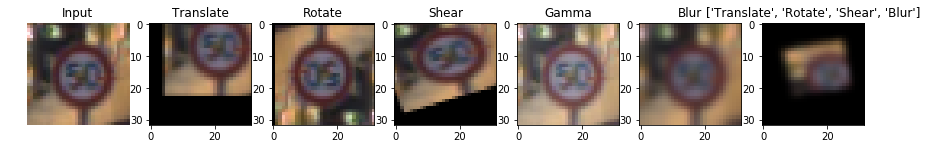

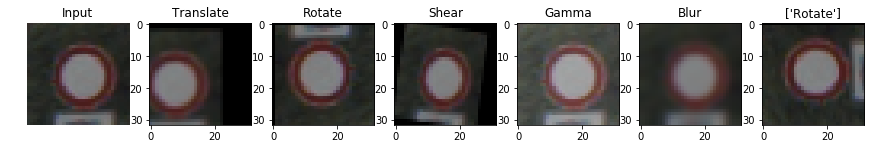

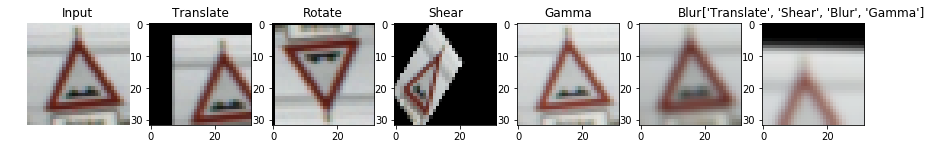

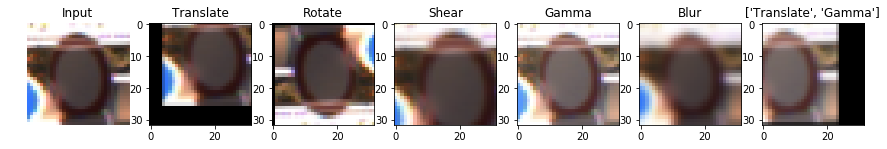

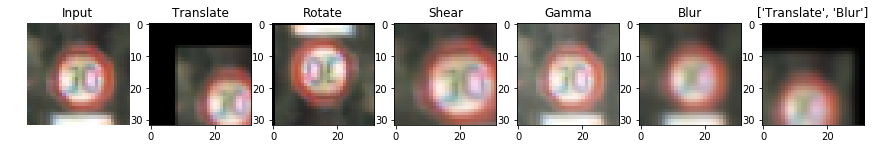

In [7]:
transform = ImageEffect()
for _ in range(5):
    samp = X_train[np.random.randint(n_train)]
    dst_translate = transform.translate(samp)
    dst_rotate = transform.rotate(samp, rotate_degree=180)
    dst_shear = transform.shear(samp)
    dst_gamma = transform.gamma(samp)
    dst_gb = transform.blur(samp)
    random_types, dst_random = transform.randomize(samp)
    plt.figure(figsize=(15, 15))
    plt.subplot(171), plt.imshow(samp), plt.axis('off'), plt.title('Input')
    plt.subplot(172), plt.imshow(dst_translate), plt.title('Translate')
    plt.subplot(173), plt.imshow(dst_rotate), plt.title('Rotate')
    plt.subplot(174), plt.imshow(dst_shear), plt.title('Shear')
    plt.subplot(175), plt.imshow(dst_gamma), plt.title('Gamma')
    plt.subplot(176), plt.imshow(dst_gb), plt.title('Blur')
    plt.subplot(177), plt.imshow(dst_random), plt.title(random_types)
plt.show()

Now that we have the augmentation techniques, to balance the training distribution, we consider the mean number of images across all classes. If the class is over-sampled, we won't augment. If the class is under-sampled, for each image in that class, we create `scale_factor * avg/len(images)` "fake images".

In [8]:
def augment_dataset(Xd, yd, scale_factor, shuffle=False, show=False):
    """Augment training dataset. Inspried from @eqbal 
    """
    n_classes = len(set(yd))
    class_idxs, images_per_class = np.unique(yd, return_counts=True)
    avg = np.ceil(np.mean(images_per_class, axis=0)).astype('uint32')
    if show:
        print("Average = ", avg)
    
    # Separate images into classes
    sep_data = []
    for idx in class_idxs:
        sep_data.append(Xd[yd==idx])
    
    expanded_Xd = np.array(np.zeros((1, 32, 32, 3)))
    expanded_yd = np.array([0])
    
    # For each class of image, calculate the number of new_images to add.
    # Then for each image, generate that many pseudo images
    transform = ImageEffect()
    for idx, orig_images in enumerate(sep_data):
        new_images = []
        factor = (scale_factor * (avg / len(orig_images))).astype('uint32')
        for img in orig_images:
            for _ in range(factor):
                new_images.append(transform.randomize(img)[1])
        if show:
            print("For class idx = {0}, factor = {1}, number of original images = {2}, number of new images added = {3}".format(idx, factor, len(orig_images), len(new_images)))
        if len(new_images) > 0:
            orig_images = np.concatenate((orig_images, new_images), axis=0)
        new_labels = np.full(len(orig_images), idx, dtype='uint8')
        expanded_Xd = np.concatenate((expanded_Xd, orig_images), axis=0)
        expanded_yd = np.concatenate((expanded_yd, new_labels), axis=0)
        
    if shuffle:
        from random import shuffle
        ind_list = [i for i in range(1, len(expanded_Xd))]
        shuffle(ind_list)
        return expanded_Xd[ind_list], expanded_yd[ind_list]
    else:
        return expanded_Xd[1:], expanded_yd[1:]  

In [9]:
expanded_X_train, expanded_y_train = augment_dataset(X_train, y_train, 2, show=True, shuffle=True)

Average =  810
For class idx = 0, factor = 9, number of original images = 180, number of new images added = 1620
For class idx = 1, factor = 0, number of original images = 1980, number of new images added = 0
For class idx = 2, factor = 0, number of original images = 2010, number of new images added = 0
For class idx = 3, factor = 1, number of original images = 1260, number of new images added = 1260
For class idx = 4, factor = 0, number of original images = 1770, number of new images added = 0
For class idx = 5, factor = 0, number of original images = 1650, number of new images added = 0
For class idx = 6, factor = 4, number of original images = 360, number of new images added = 1440
For class idx = 7, factor = 1, number of original images = 1290, number of new images added = 1290
For class idx = 8, factor = 1, number of original images = 1260, number of new images added = 1260
For class idx = 9, factor = 1, number of original images = 1320, number of new images added = 1320
For class

After plotting the distributions before and after augmentation, distribution of images among classes is more balanced. No class is under-sampled.

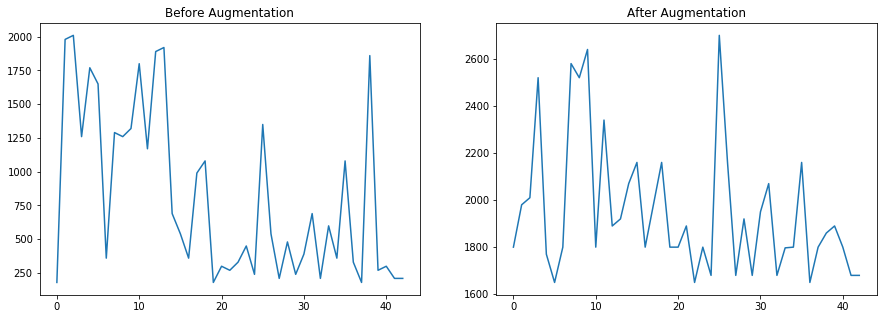

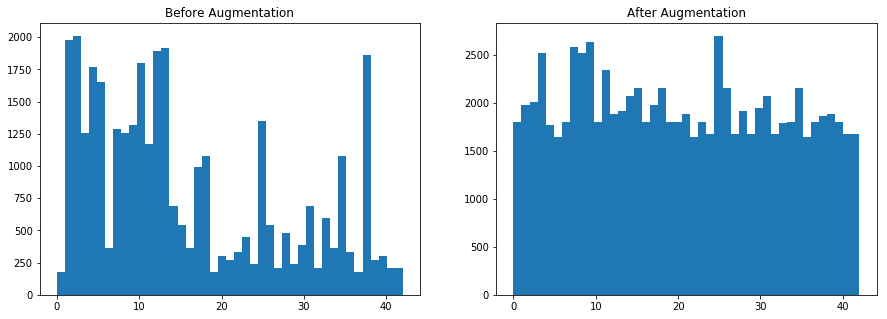

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(121), plt.plot(np.bincount(y_train)), plt.title('Before Augmentation')
plt.subplot(122), plt.plot(np.bincount(expanded_y_train)), plt.title('After Augmentation')
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(121), plt.hist(y_train, bins=n_classes), plt.title('Before Augmentation')
plt.subplot(122), plt.hist(expanded_y_train, bins=n_classes), plt.title('After Augmentation')
plt.show()

## 3. Train a simple LeNet Model

For this task, I used PyTorch instead Tensorflow to build dynamic graphs. The training framework is inspired from the Stanford CS231n class assignment as documented <a href="https://github.com/lmtoan/CS231n-Vision/blob/master/assignment2_1617/PyTorch_Toan.ipynb">here</a>. 

First, import all PyTorch packages.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import copy
import torch.utils.data as data_utils

Then, using `torch.utils.data.TensorDataset`, I converted numpy training/validation/test image matrices into tensors.

Using `torch.utils.data.TensorDataset`, I sampled batches of 64 images from the `traffic_train` and `traffic_val` tensors.

In [74]:
traffic_train = data_utils.TensorDataset(torch.from_numpy(np.transpose(expanded_X_train/255.0, (0,3,1,2))), torch.from_numpy(expanded_y_train))
loader_train = data_utils.DataLoader(traffic_train, batch_size=64, shuffle=True)

traffic_val = data_utils.TensorDataset(torch.from_numpy(np.transpose(X_valid/255.0, (0,3,1,2))), torch.from_numpy(y_valid))
loader_val = data_utils.DataLoader(traffic_val, batch_size=64, shuffle=True)

traffic_test = data_utils.TensorDataset(torch.from_numpy(np.transpose(X_test/255.0, (0,3,1,2))), torch.from_numpy(y_test))
loader_test = data_utils.DataLoader(traffic_test, batch_size=64, shuffle=True)

Helper functions to flatten a multi-dimensional Tensors to 2-D Tensors ready to be fit in Softmax

In [13]:
use_gpu = torch.cuda.is_available()
print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        # print(N, C, H, W)
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

I built a simple LeNet structure using `nn.Sequential`. To check the final output dimensions, I feed in a random Torch tensors of `(64, 3, 32, 32)` to get an output Tensor of `(64, 43)` which is the scores for 43 classes of 64 input Tensors. 

In [14]:
lenet = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5),
    nn.ReLU(inplace=True),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(p=0.5),
    Flatten(),
    nn.Linear(16*12*12, 120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.ReLU(inplace=True),
    nn.Linear(84, n_classes))

lenet(Variable(torch.randn(64, 3, 32, 32))).size()

torch.Size([64, 43])

I wrote a `train` script to perform training for a certain number of epoches. After each epoch, the script will cycle through the validation set to calculate the accuracy. If it is more than best accuracy so far, the model state is saved. 

In [62]:
import time

def train(model, loss_fn, optimizer, num_epochs=1, plot=True, use_gpu=True):
    reset(model)
    start_time = str(round(time.clock()))
    best_accuracy = 0.0
    best_model = model
    
    for epoch in range(num_epochs):
        print("--------------")
        print("Starting epoch %d / %d" % (epoch + 1, num_epochs))
        loader = None
        epoch_loss = None
        epoch_accuracy = None
        
        for phase in ['train', 'val']:
            if phase == "train":
                model.train() # Put model in training mode
                loader = loader_train
            else:
                model.eval() # Put model in evaluation mode
                loader = loader_val
         
            running_loss = 0.0
            running_corrects = 0
            losses = []
            accuracies = []
            num_samples = 0

            for t, (x, y) in enumerate(loader):
                if use_gpu:
                    x_var = Variable(x.float().cuda())
                    y_var = Variable(y.long().cuda())
                else:
                    x_var = Variable(x.float())
                    y_var = Variable(y.long())

                scores = model(x_var)
                _, preds = torch.max(scores.data, 1)
                loss = loss_fn(scores, y_var)

                batch_size = preds.size(0)
                batch_loss = loss.data[0]
                batch_corrects = torch.sum(preds == y_var.data)
                batch_acc = batch_corrects / batch_size

                losses.append(batch_loss)
                accuracies.append(batch_acc)
                running_loss += batch_loss * batch_size
                running_corrects += batch_corrects

                num_samples += batch_size
                
                # Don't print on validation.
                if phase == "train" and (t + 1) % print_every == 0:
                    print('t = %d, loss = %.4f, acc = %.4f' % (t + 1, batch_loss, batch_acc))
                
                # Only perform training steps on training.
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    
            if phase == "train" and plot:
                fig, ax = plt.subplots(figsize=(10, 5))
                plt.grid(True)

                line1, = ax.plot(losses, label='Losses')
                line2, = ax.plot(accuracies, label='Accuracy')

                ax.legend(loc='lower right')
                plt.title('Epoch {} Loss'.format(epoch+1))
                plt.xlabel('Minibatch Number')
                plt.show()
                
            epoch_loss = running_loss / num_samples
            epoch_acc = running_corrects / num_samples

            print('Phase {}, Epoch {}, Overall Loss: {:.4f} and Accuracy: {:.4f}'.format(phase, epoch+1, epoch_loss, epoch_acc))
            
            # After each epoch, get the average accuracy across all validation batches
            # If accuracy is best so far, store the model. 
            if phase == "val" and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model = copy.deepcopy(model) # Update the best model.
                print ("=> Saving a new best")
                torch.save({'epoch': epoch + 1,
                            'state_dict': model.state_dict(),
                            'best_accuracy': best_accuracy}, "checkpoint.best_of_{}.pth.tar".format(start_time))
    return best_model

I trained the LeNet structure with starting `lr = 0.001` and `momentum = 0.9` for 50 epoches. The best is obtained at `Epoch 39, Overall Loss: 0.2473 and Accuracy: 0.9385`. At this point, the training is most likely plateaued and requires further tuning.

In [64]:
lenet = lenet.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=0.001, momentum=0.9, dampening=0, weight_decay=0.0005, nesterov=True)
best_lenet = train(lenet, loss_fn, optimizer, num_epochs=50, plot=False)

--------------
Starting epoch 1 / 50
t = 100, loss = 0.7943, acc = 0.7500
t = 200, loss = 0.4573, acc = 0.8594
t = 300, loss = 0.7056, acc = 0.7812
t = 400, loss = 1.0574, acc = 0.6406
t = 500, loss = 0.6673, acc = 0.7656
t = 600, loss = 0.4947, acc = 0.8125
t = 700, loss = 0.6923, acc = 0.8125
t = 800, loss = 0.7138, acc = 0.7656
t = 900, loss = 0.5472, acc = 0.8281
t = 1000, loss = 0.8336, acc = 0.7031
t = 1100, loss = 0.8129, acc = 0.7344
t = 1200, loss = 0.6799, acc = 0.7812
t = 1300, loss = 0.7628, acc = 0.7969
Phase train, Epoch 1, Overall Loss: 0.6334 and Accuracy: 0.8008
Phase val, Epoch 1, Overall Loss: 0.2701 and Accuracy: 0.9249
=> Saving a new best
--------------
Starting epoch 2 / 50
t = 100, loss = 0.5836, acc = 0.8125
t = 200, loss = 0.7138, acc = 0.7969
t = 300, loss = 0.5855, acc = 0.7812
t = 400, loss = 0.4966, acc = 0.8281
t = 500, loss = 0.6144, acc = 0.8125
t = 600, loss = 0.4713, acc = 0.8281
t = 700, loss = 0.6643, acc = 0.7812
t = 800, loss = 0.7011, acc = 0.796

t = 1000, loss = 0.4800, acc = 0.8438
t = 1100, loss = 0.3569, acc = 0.9375
t = 1200, loss = 0.4605, acc = 0.8750
t = 1300, loss = 0.3952, acc = 0.8906
Phase train, Epoch 13, Overall Loss: 0.5189 and Accuracy: 0.8333
Phase val, Epoch 13, Overall Loss: 0.2705 and Accuracy: 0.9299
--------------
Starting epoch 14 / 50
t = 100, loss = 0.3109, acc = 0.9062
t = 200, loss = 0.5010, acc = 0.8438
t = 300, loss = 0.4747, acc = 0.8438
t = 400, loss = 0.4626, acc = 0.8438
t = 500, loss = 0.2912, acc = 0.8906
t = 600, loss = 0.3731, acc = 0.8750
t = 700, loss = 0.3830, acc = 0.8594
t = 800, loss = 0.5575, acc = 0.8906
t = 900, loss = 0.6187, acc = 0.7969
t = 1000, loss = 0.6127, acc = 0.7656
t = 1100, loss = 0.4696, acc = 0.8281
t = 1200, loss = 0.6856, acc = 0.7656
t = 1300, loss = 0.7747, acc = 0.8125
Phase train, Epoch 14, Overall Loss: 0.5103 and Accuracy: 0.8366
Phase val, Epoch 14, Overall Loss: 0.2814 and Accuracy: 0.9238
--------------
Starting epoch 15 / 50
t = 100, loss = 0.5664, acc = 0

t = 100, loss = 0.6932, acc = 0.8281
t = 200, loss = 0.3483, acc = 0.8594
t = 300, loss = 0.5230, acc = 0.7969
t = 400, loss = 0.3138, acc = 0.9375
t = 500, loss = 0.3059, acc = 0.8750
t = 600, loss = 0.5546, acc = 0.8438
t = 700, loss = 0.5823, acc = 0.8125
t = 800, loss = 0.5241, acc = 0.8438
t = 900, loss = 0.5151, acc = 0.7812
t = 1000, loss = 0.3679, acc = 0.8594
t = 1100, loss = 0.4164, acc = 0.8438
t = 1200, loss = 0.4062, acc = 0.8438
t = 1300, loss = 0.4986, acc = 0.8594
Phase train, Epoch 26, Overall Loss: 0.4481 and Accuracy: 0.8547
Phase val, Epoch 26, Overall Loss: 0.2846 and Accuracy: 0.9336
--------------
Starting epoch 27 / 50
t = 100, loss = 0.6428, acc = 0.7969
t = 200, loss = 0.3896, acc = 0.8438
t = 300, loss = 0.4642, acc = 0.7812
t = 400, loss = 0.3609, acc = 0.8750
t = 500, loss = 0.4715, acc = 0.8281
t = 600, loss = 0.3888, acc = 0.8906
t = 700, loss = 0.4963, acc = 0.8281
t = 800, loss = 0.4284, acc = 0.8438
t = 900, loss = 0.3163, acc = 0.9219
t = 1000, loss =

t = 1200, loss = 0.3768, acc = 0.8906
t = 1300, loss = 0.4058, acc = 0.8438
Phase train, Epoch 38, Overall Loss: 0.4074 and Accuracy: 0.8674
Phase val, Epoch 38, Overall Loss: 0.2878 and Accuracy: 0.9379
=> Saving a new best
--------------
Starting epoch 39 / 50
t = 100, loss = 0.5467, acc = 0.8594
t = 200, loss = 0.4206, acc = 0.8750
t = 300, loss = 0.4579, acc = 0.8594
t = 400, loss = 0.3868, acc = 0.8750
t = 500, loss = 0.3654, acc = 0.8906
t = 600, loss = 0.3314, acc = 0.8906
t = 700, loss = 0.4556, acc = 0.8281
t = 800, loss = 0.5542, acc = 0.8438
t = 900, loss = 0.3420, acc = 0.9219
t = 1000, loss = 0.4243, acc = 0.8281
t = 1100, loss = 0.4752, acc = 0.8281
t = 1200, loss = 0.5680, acc = 0.8125
t = 1300, loss = 0.3890, acc = 0.8906
Phase train, Epoch 39, Overall Loss: 0.4061 and Accuracy: 0.8693
Phase val, Epoch 39, Overall Loss: 0.2473 and Accuracy: 0.9385
=> Saving a new best
--------------
Starting epoch 40 / 50
t = 100, loss = 0.3627, acc = 0.9062
t = 200, loss = 0.6605, acc 

## 4. Train a fancier model

The MobileNet is sourced from this <a href="https://github.com/kuangliu/pytorch-cifar/tree/master/models">Github repo</a> that is intially used for CIFAR10 dataset of similar dimension 32x32.

Due to a more complicated structure, the training took longer to complete.

In [65]:
import torch.nn.functional as F

class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, n_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

--------------
Starting epoch 1 / 40
t = 100, loss = 3.0256, acc = 0.1406
t = 200, loss = 2.6749, acc = 0.2031
t = 300, loss = 2.1787, acc = 0.2969
t = 400, loss = 2.2537, acc = 0.2812
t = 500, loss = 1.7882, acc = 0.4062
t = 600, loss = 1.8833, acc = 0.3438
t = 700, loss = 1.5653, acc = 0.5156
t = 800, loss = 1.3857, acc = 0.5469
t = 900, loss = 1.5206, acc = 0.5156
t = 1000, loss = 1.4231, acc = 0.5312
t = 1100, loss = 0.8605, acc = 0.7188
t = 1200, loss = 1.2132, acc = 0.6406
t = 1300, loss = 0.7133, acc = 0.7656


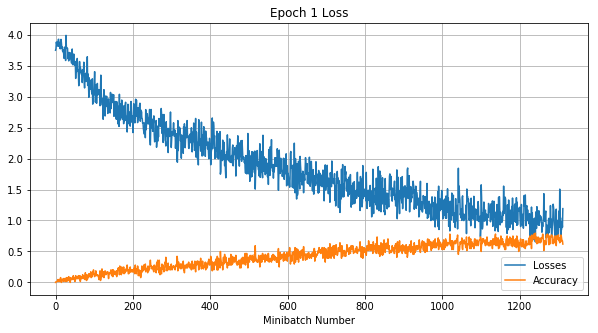

Phase train, Epoch 1, Overall Loss: 1.8727 and Accuracy: 0.4262
Phase val, Epoch 1, Overall Loss: 0.5520 and Accuracy: 0.8297
=> Saving a new best
--------------
Starting epoch 2 / 40
t = 100, loss = 0.7829, acc = 0.7969
t = 200, loss = 0.9850, acc = 0.7031
t = 300, loss = 0.6493, acc = 0.7656
t = 400, loss = 0.9548, acc = 0.6875
t = 500, loss = 0.6385, acc = 0.8281
t = 600, loss = 0.6991, acc = 0.7656
t = 700, loss = 0.8573, acc = 0.7656
t = 800, loss = 0.7498, acc = 0.7344
t = 900, loss = 0.7675, acc = 0.7656
t = 1000, loss = 0.7874, acc = 0.7500
t = 1100, loss = 0.6383, acc = 0.7812
t = 1200, loss = 0.4477, acc = 0.8125
t = 1300, loss = 0.6045, acc = 0.8281


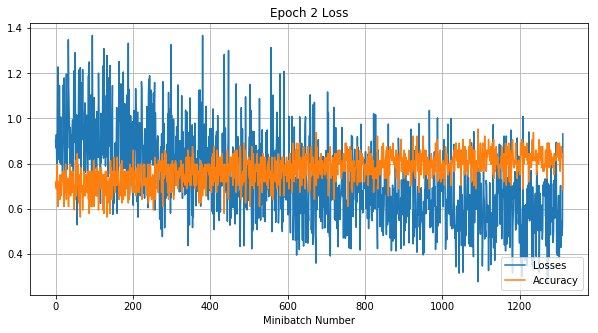

Phase train, Epoch 2, Overall Loss: 0.7309 and Accuracy: 0.7732
Phase val, Epoch 2, Overall Loss: 0.4055 and Accuracy: 0.8810
=> Saving a new best
--------------
Starting epoch 3 / 40
t = 100, loss = 0.6347, acc = 0.8125
t = 200, loss = 0.5349, acc = 0.8906
t = 300, loss = 0.5272, acc = 0.8281
t = 400, loss = 0.3949, acc = 0.8438
t = 500, loss = 0.4808, acc = 0.8594
t = 600, loss = 0.4381, acc = 0.8906
t = 700, loss = 0.6226, acc = 0.8906
t = 800, loss = 0.3384, acc = 0.9062
t = 900, loss = 0.5205, acc = 0.8438
t = 1000, loss = 0.3739, acc = 0.8750
t = 1100, loss = 0.4285, acc = 0.8906
t = 1200, loss = 0.5889, acc = 0.7969
t = 1300, loss = 0.4883, acc = 0.8438


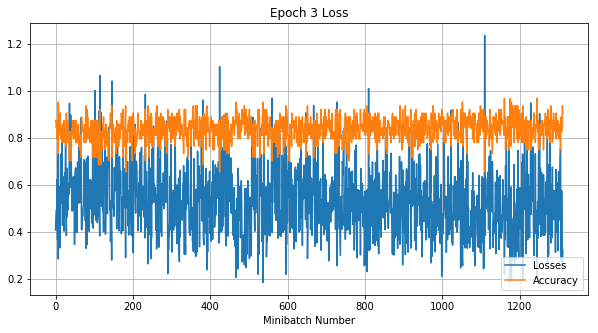

Phase train, Epoch 3, Overall Loss: 0.5337 and Accuracy: 0.8385
Phase val, Epoch 3, Overall Loss: 0.5416 and Accuracy: 0.8517
--------------
Starting epoch 4 / 40
t = 100, loss = 0.3213, acc = 0.8906
t = 200, loss = 0.4783, acc = 0.8750
t = 300, loss = 0.5628, acc = 0.8281
t = 400, loss = 0.7673, acc = 0.7812
t = 500, loss = 0.6090, acc = 0.8281
t = 600, loss = 0.6234, acc = 0.8281
t = 700, loss = 0.2919, acc = 0.9219
t = 800, loss = 0.4475, acc = 0.8594
t = 900, loss = 0.3708, acc = 0.8594
t = 1000, loss = 0.3654, acc = 0.8906
t = 1100, loss = 0.6084, acc = 0.8125
t = 1200, loss = 0.6189, acc = 0.7969
t = 1300, loss = 0.3837, acc = 0.8750


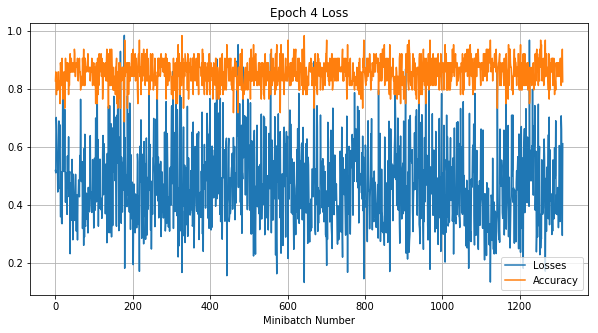

Phase train, Epoch 4, Overall Loss: 0.4737 and Accuracy: 0.8591
Phase val, Epoch 4, Overall Loss: 0.5136 and Accuracy: 0.8444
--------------
Starting epoch 5 / 40
t = 100, loss = 0.4962, acc = 0.8281
t = 200, loss = 0.6308, acc = 0.8125
t = 300, loss = 0.1203, acc = 0.9688
t = 400, loss = 0.2558, acc = 0.9375
t = 500, loss = 0.4875, acc = 0.8281
t = 600, loss = 0.4028, acc = 0.9062
t = 700, loss = 0.5732, acc = 0.8750
t = 800, loss = 0.4151, acc = 0.8906
t = 900, loss = 0.3377, acc = 0.8906
t = 1000, loss = 0.6361, acc = 0.7969
t = 1100, loss = 0.5026, acc = 0.8594
t = 1200, loss = 0.5203, acc = 0.8594
t = 1300, loss = 0.4454, acc = 0.9062


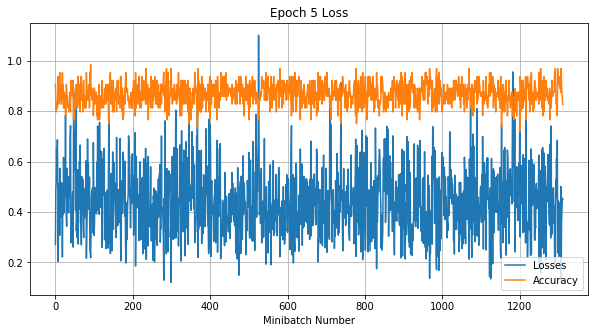

Phase train, Epoch 5, Overall Loss: 0.4385 and Accuracy: 0.8691
Phase val, Epoch 5, Overall Loss: 0.2310 and Accuracy: 0.9392
=> Saving a new best
--------------
Starting epoch 6 / 40
t = 100, loss = 0.3905, acc = 0.8594
t = 200, loss = 0.3399, acc = 0.8906
t = 300, loss = 0.6979, acc = 0.7969
t = 400, loss = 0.3145, acc = 0.8906
t = 500, loss = 0.3809, acc = 0.9062
t = 600, loss = 0.3930, acc = 0.9219
t = 700, loss = 0.5261, acc = 0.7969
t = 800, loss = 0.5698, acc = 0.8281
t = 900, loss = 0.4365, acc = 0.8750
t = 1000, loss = 0.5443, acc = 0.7969
t = 1100, loss = 0.3844, acc = 0.9062
t = 1200, loss = 0.2468, acc = 0.9219
t = 1300, loss = 0.4354, acc = 0.8438


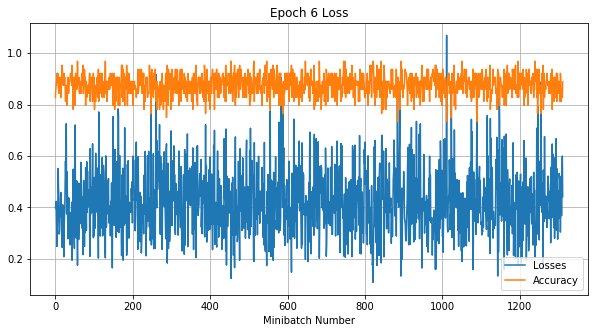

Phase train, Epoch 6, Overall Loss: 0.4221 and Accuracy: 0.8762
Phase val, Epoch 6, Overall Loss: 0.2796 and Accuracy: 0.9274
--------------
Starting epoch 7 / 40
t = 100, loss = 0.4882, acc = 0.8750
t = 200, loss = 0.3364, acc = 0.8750
t = 300, loss = 0.3592, acc = 0.8594
t = 400, loss = 0.4111, acc = 0.8906
t = 500, loss = 0.3787, acc = 0.8906
t = 600, loss = 0.3535, acc = 0.8594
t = 700, loss = 0.5641, acc = 0.8594
t = 800, loss = 0.2880, acc = 0.9219
t = 900, loss = 0.2373, acc = 0.9531
t = 1000, loss = 0.3188, acc = 0.9219
t = 1100, loss = 0.3905, acc = 0.8594
t = 1200, loss = 0.3339, acc = 0.9219
t = 1300, loss = 0.4436, acc = 0.8906


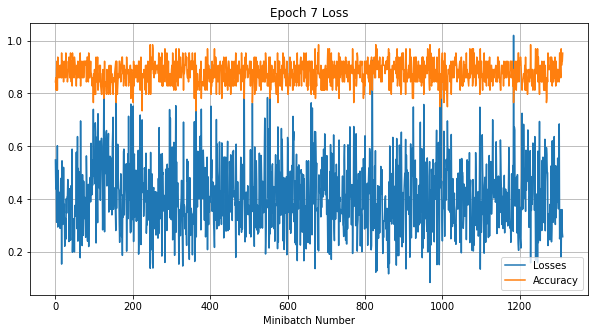

Phase train, Epoch 7, Overall Loss: 0.4142 and Accuracy: 0.8787
Phase val, Epoch 7, Overall Loss: 0.3971 and Accuracy: 0.8803
--------------
Starting epoch 8 / 40
t = 100, loss = 0.3217, acc = 0.9062
t = 200, loss = 0.3058, acc = 0.9062
t = 300, loss = 0.4480, acc = 0.8906
t = 400, loss = 0.6321, acc = 0.8281
t = 500, loss = 0.4218, acc = 0.9062
t = 600, loss = 0.7810, acc = 0.8438
t = 700, loss = 0.2889, acc = 0.9062
t = 800, loss = 0.2860, acc = 0.9062
t = 900, loss = 0.3522, acc = 0.8906
t = 1000, loss = 0.2033, acc = 0.9219
t = 1100, loss = 0.4949, acc = 0.8438
t = 1200, loss = 0.4655, acc = 0.8438
t = 1300, loss = 0.4453, acc = 0.9062


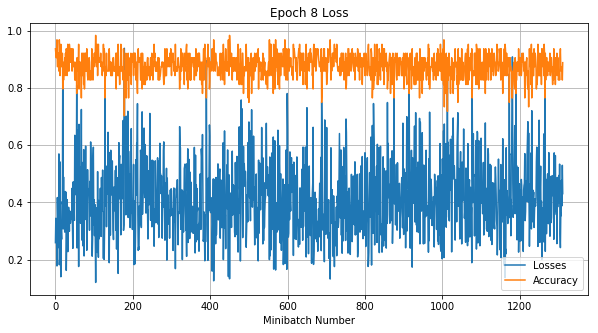

Phase train, Epoch 8, Overall Loss: 0.4129 and Accuracy: 0.8780
Phase val, Epoch 8, Overall Loss: 0.4010 and Accuracy: 0.8789
--------------
Starting epoch 9 / 40
t = 100, loss = 0.4654, acc = 0.8438
t = 200, loss = 0.3722, acc = 0.8906
t = 300, loss = 0.3858, acc = 0.8438
t = 400, loss = 0.3176, acc = 0.9219
t = 500, loss = 0.4562, acc = 0.8594
t = 600, loss = 0.5797, acc = 0.8125
t = 700, loss = 0.7261, acc = 0.7812
t = 800, loss = 0.4420, acc = 0.8594
t = 900, loss = 0.3640, acc = 0.8906
t = 1000, loss = 0.7572, acc = 0.8125
t = 1100, loss = 0.2153, acc = 0.9531
t = 1200, loss = 0.4396, acc = 0.8906
t = 1300, loss = 0.5897, acc = 0.8125


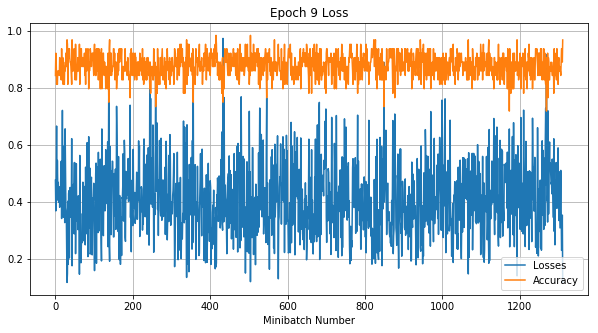

Phase train, Epoch 9, Overall Loss: 0.4106 and Accuracy: 0.8797
Phase val, Epoch 9, Overall Loss: 0.2717 and Accuracy: 0.9293
--------------
Starting epoch 10 / 40
t = 100, loss = 0.4234, acc = 0.8750
t = 200, loss = 0.2571, acc = 0.9062
t = 300, loss = 0.2807, acc = 0.9219
t = 400, loss = 0.3148, acc = 0.9062
t = 500, loss = 0.2013, acc = 0.9531
t = 600, loss = 0.2741, acc = 0.9062
t = 700, loss = 0.3237, acc = 0.9375
t = 800, loss = 0.4135, acc = 0.8750
t = 900, loss = 0.2171, acc = 0.9375
t = 1000, loss = 0.3591, acc = 0.9062
t = 1100, loss = 0.4054, acc = 0.8906
t = 1200, loss = 0.4460, acc = 0.9062
t = 1300, loss = 0.3877, acc = 0.9531


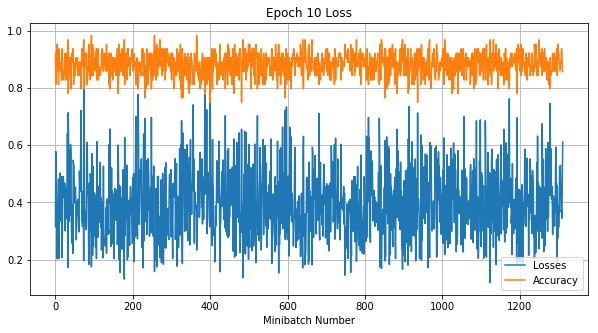

Phase train, Epoch 10, Overall Loss: 0.3980 and Accuracy: 0.8833
Phase val, Epoch 10, Overall Loss: 0.2470 and Accuracy: 0.9220
--------------
Starting epoch 11 / 40
t = 100, loss = 0.3681, acc = 0.8750
t = 200, loss = 0.5960, acc = 0.7969
t = 300, loss = 0.3069, acc = 0.9219
t = 400, loss = 0.5625, acc = 0.8594
t = 500, loss = 0.3656, acc = 0.8594
t = 600, loss = 0.5426, acc = 0.8125
t = 700, loss = 0.4893, acc = 0.8281
t = 800, loss = 0.5148, acc = 0.8906
t = 900, loss = 0.4594, acc = 0.8438
t = 1000, loss = 0.1139, acc = 0.9844
t = 1100, loss = 0.1917, acc = 0.9531
t = 1200, loss = 0.4481, acc = 0.8438
t = 1300, loss = 0.3189, acc = 0.8594


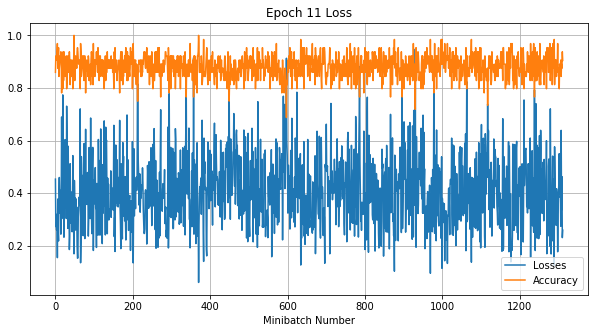

Phase train, Epoch 11, Overall Loss: 0.4077 and Accuracy: 0.8804
Phase val, Epoch 11, Overall Loss: 0.3855 and Accuracy: 0.9025
--------------
Starting epoch 12 / 40
t = 100, loss = 0.2734, acc = 0.9062
t = 200, loss = 0.3876, acc = 0.8750
t = 300, loss = 0.2551, acc = 0.9219
t = 400, loss = 0.5970, acc = 0.8125
t = 500, loss = 0.3598, acc = 0.9062
t = 600, loss = 0.3776, acc = 0.8906
t = 700, loss = 0.5276, acc = 0.8594
t = 800, loss = 0.2925, acc = 0.9062
t = 900, loss = 0.2978, acc = 0.9062
t = 1000, loss = 0.2732, acc = 0.9219
t = 1100, loss = 0.3024, acc = 0.9062
t = 1200, loss = 0.6050, acc = 0.8281
t = 1300, loss = 0.4461, acc = 0.8281


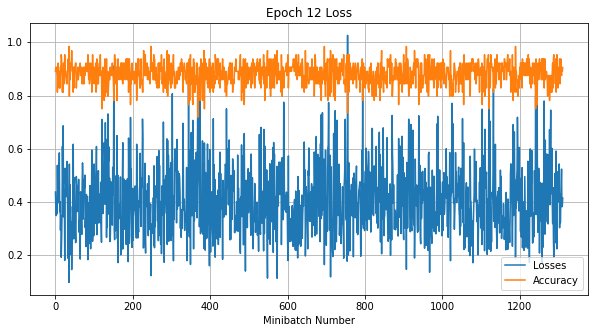

Phase train, Epoch 12, Overall Loss: 0.4055 and Accuracy: 0.8820
Phase val, Epoch 12, Overall Loss: 0.1795 and Accuracy: 0.9553
=> Saving a new best
--------------
Starting epoch 13 / 40
t = 100, loss = 0.3356, acc = 0.9062
t = 200, loss = 0.4552, acc = 0.8594
t = 300, loss = 0.4892, acc = 0.8750
t = 400, loss = 0.3129, acc = 0.8750
t = 500, loss = 0.4477, acc = 0.8594
t = 600, loss = 0.2753, acc = 0.9375
t = 700, loss = 0.2004, acc = 0.9375
t = 800, loss = 0.4726, acc = 0.8594
t = 900, loss = 0.2445, acc = 0.9375
t = 1000, loss = 0.4534, acc = 0.8906
t = 1100, loss = 0.3241, acc = 0.9062
t = 1200, loss = 0.4999, acc = 0.8906
t = 1300, loss = 0.2491, acc = 0.9219


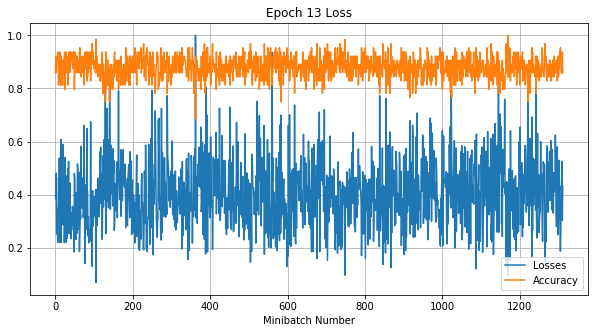

Phase train, Epoch 13, Overall Loss: 0.4045 and Accuracy: 0.8805
Phase val, Epoch 13, Overall Loss: 0.2524 and Accuracy: 0.9215
--------------
Starting epoch 14 / 40
t = 100, loss = 0.3434, acc = 0.9375
t = 200, loss = 0.4610, acc = 0.8438
t = 300, loss = 0.6325, acc = 0.8438
t = 400, loss = 0.4621, acc = 0.8594
t = 500, loss = 0.4518, acc = 0.8750
t = 600, loss = 0.3903, acc = 0.8594
t = 700, loss = 0.5759, acc = 0.8594
t = 800, loss = 0.4246, acc = 0.8438
t = 900, loss = 0.3760, acc = 0.8750
t = 1000, loss = 0.2488, acc = 0.8906
t = 1100, loss = 0.4692, acc = 0.8750
t = 1200, loss = 1.1064, acc = 0.7188
t = 1300, loss = 0.4802, acc = 0.8750


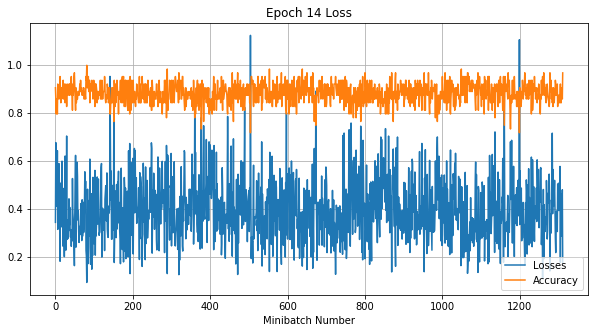

Phase train, Epoch 14, Overall Loss: 0.3997 and Accuracy: 0.8836
Phase val, Epoch 14, Overall Loss: 0.3018 and Accuracy: 0.9077
--------------
Starting epoch 15 / 40
t = 100, loss = 0.4980, acc = 0.8438
t = 200, loss = 0.5176, acc = 0.8594
t = 300, loss = 0.2119, acc = 0.9375
t = 400, loss = 0.4924, acc = 0.8594
t = 500, loss = 0.3714, acc = 0.8906
t = 600, loss = 0.5590, acc = 0.8594
t = 700, loss = 0.2380, acc = 0.9375
t = 800, loss = 0.7512, acc = 0.8125
t = 900, loss = 0.2830, acc = 0.9062
t = 1000, loss = 0.6267, acc = 0.8125
t = 1100, loss = 0.3425, acc = 0.8750
t = 1200, loss = 0.5031, acc = 0.8281
t = 1300, loss = 0.2824, acc = 0.9219


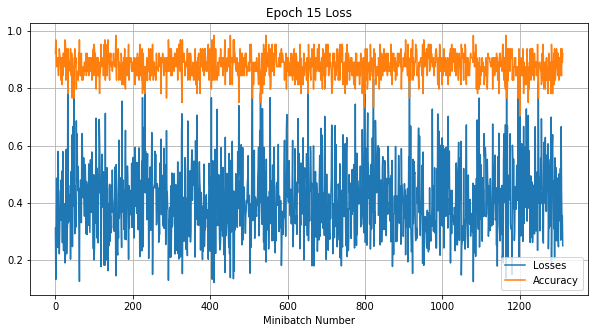

Phase train, Epoch 15, Overall Loss: 0.4126 and Accuracy: 0.8797
Phase val, Epoch 15, Overall Loss: 0.4174 and Accuracy: 0.8810
--------------
Starting epoch 16 / 40
t = 100, loss = 0.2832, acc = 0.9375
t = 200, loss = 0.6682, acc = 0.8125
t = 300, loss = 0.5436, acc = 0.8750
t = 400, loss = 0.4734, acc = 0.8438
t = 500, loss = 0.2444, acc = 0.8906
t = 600, loss = 0.3171, acc = 0.8906
t = 700, loss = 0.4011, acc = 0.8906
t = 800, loss = 0.1447, acc = 0.9688
t = 900, loss = 0.4039, acc = 0.8750
t = 1000, loss = 0.5282, acc = 0.8438
t = 1100, loss = 0.7221, acc = 0.8750
t = 1200, loss = 0.3417, acc = 0.9219
t = 1300, loss = 0.6465, acc = 0.7812


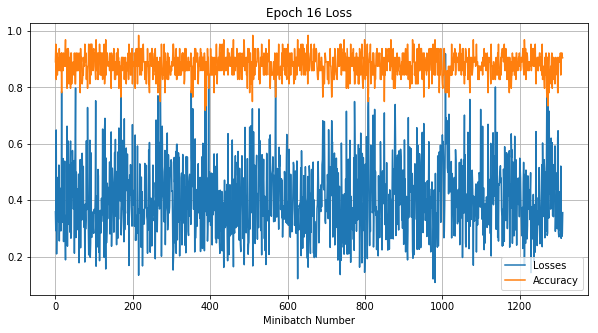

Phase train, Epoch 16, Overall Loss: 0.4071 and Accuracy: 0.8811
Phase val, Epoch 16, Overall Loss: 0.5906 and Accuracy: 0.8458
--------------
Starting epoch 17 / 40
t = 100, loss = 0.3407, acc = 0.9219
t = 200, loss = 0.4185, acc = 0.9062
t = 300, loss = 0.4417, acc = 0.8750
t = 400, loss = 0.5888, acc = 0.7969
t = 500, loss = 0.1671, acc = 0.9688
t = 600, loss = 0.2159, acc = 0.9375
t = 700, loss = 0.2212, acc = 0.9219
t = 800, loss = 0.2868, acc = 0.9062
t = 900, loss = 0.5687, acc = 0.8281
t = 1000, loss = 0.5404, acc = 0.8281
t = 1100, loss = 0.3132, acc = 0.9219
t = 1200, loss = 0.4231, acc = 0.8594
t = 1300, loss = 0.4464, acc = 0.8750


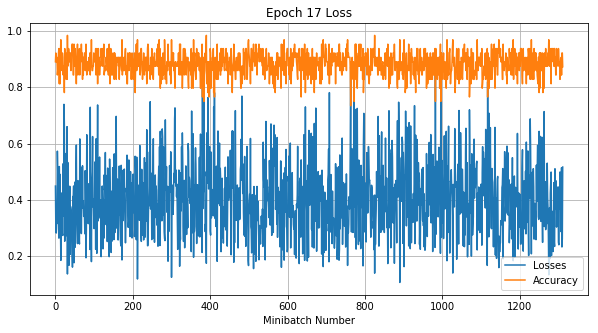

Phase train, Epoch 17, Overall Loss: 0.4036 and Accuracy: 0.8830
Phase val, Epoch 17, Overall Loss: 0.1806 and Accuracy: 0.9467
--------------
Starting epoch 18 / 40
t = 100, loss = 0.2560, acc = 0.9375
t = 200, loss = 0.4722, acc = 0.8438
t = 300, loss = 0.2987, acc = 0.9219
t = 400, loss = 0.4051, acc = 0.9062
t = 500, loss = 0.3609, acc = 0.9062
t = 600, loss = 0.3519, acc = 0.8750
t = 700, loss = 0.5186, acc = 0.8438
t = 800, loss = 0.2259, acc = 0.9375
t = 900, loss = 0.3076, acc = 0.8906
t = 1000, loss = 0.4386, acc = 0.8750
t = 1100, loss = 0.5579, acc = 0.8438
t = 1200, loss = 0.2897, acc = 0.9375
t = 1300, loss = 0.2323, acc = 0.9531


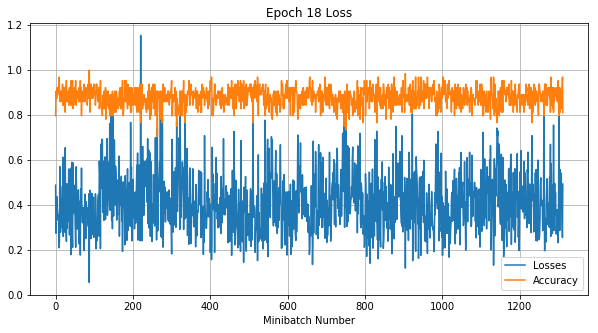

Phase train, Epoch 18, Overall Loss: 0.4119 and Accuracy: 0.8791
Phase val, Epoch 18, Overall Loss: 0.2757 and Accuracy: 0.9299
--------------
Starting epoch 19 / 40
t = 100, loss = 0.4819, acc = 0.8438
t = 200, loss = 0.7769, acc = 0.7344
t = 300, loss = 0.4523, acc = 0.8750
t = 400, loss = 0.3531, acc = 0.8281
t = 500, loss = 0.4899, acc = 0.8281
t = 600, loss = 0.4258, acc = 0.8750
t = 700, loss = 0.4623, acc = 0.8750
t = 800, loss = 0.1433, acc = 0.9375
t = 900, loss = 0.2600, acc = 0.9531
t = 1000, loss = 0.6330, acc = 0.8281
t = 1100, loss = 0.2866, acc = 0.9062
t = 1200, loss = 0.7044, acc = 0.7656
t = 1300, loss = 0.3828, acc = 0.8906


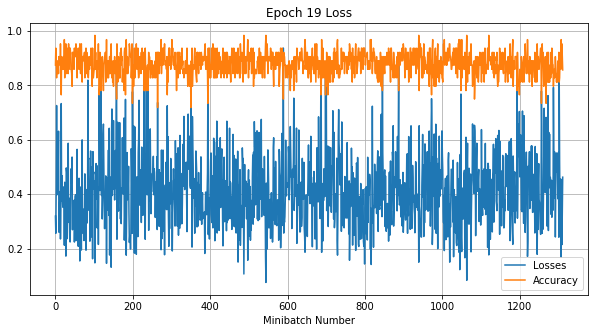

Phase train, Epoch 19, Overall Loss: 0.4142 and Accuracy: 0.8798
Phase val, Epoch 19, Overall Loss: 0.3975 and Accuracy: 0.8823
--------------
Starting epoch 20 / 40
t = 100, loss = 0.2204, acc = 0.9375
t = 200, loss = 0.3567, acc = 0.8750
t = 300, loss = 0.6042, acc = 0.8125
t = 400, loss = 0.0998, acc = 0.9844
t = 500, loss = 0.3658, acc = 0.9062
t = 600, loss = 0.3533, acc = 0.8750
t = 700, loss = 0.8277, acc = 0.8594
t = 800, loss = 0.4360, acc = 0.8750
t = 900, loss = 0.5434, acc = 0.8750
t = 1000, loss = 0.5629, acc = 0.8281
t = 1100, loss = 0.4134, acc = 0.8906
t = 1200, loss = 0.4064, acc = 0.8750
t = 1300, loss = 0.6908, acc = 0.8438


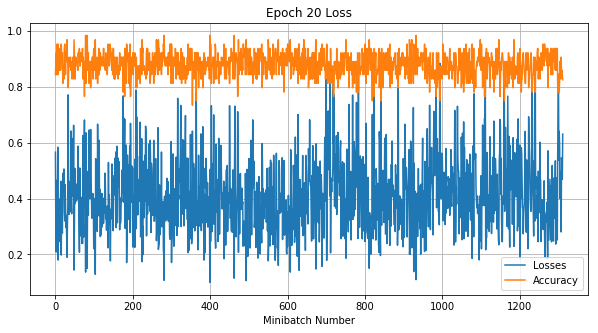

Phase train, Epoch 20, Overall Loss: 0.4124 and Accuracy: 0.8797
Phase val, Epoch 20, Overall Loss: 0.3200 and Accuracy: 0.9057
--------------
Starting epoch 21 / 40
t = 100, loss = 0.4192, acc = 0.8906
t = 200, loss = 0.5047, acc = 0.8594
t = 300, loss = 0.6189, acc = 0.8906
t = 400, loss = 0.3632, acc = 0.9062
t = 500, loss = 0.3049, acc = 0.9375
t = 600, loss = 0.7160, acc = 0.7656
t = 700, loss = 0.2776, acc = 0.9531
t = 800, loss = 0.2677, acc = 0.9375
t = 900, loss = 0.2062, acc = 0.9531
t = 1000, loss = 0.4913, acc = 0.8281
t = 1100, loss = 0.3826, acc = 0.8594
t = 1200, loss = 0.3543, acc = 0.9062
t = 1300, loss = 0.3309, acc = 0.9219


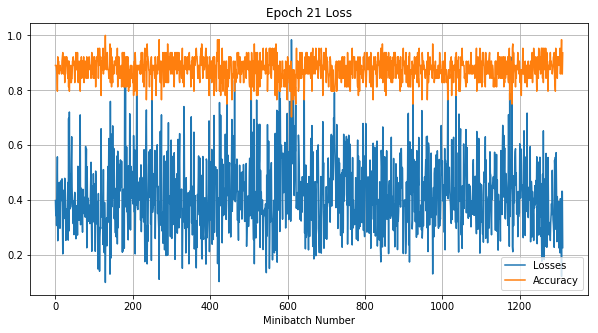

Phase train, Epoch 21, Overall Loss: 0.4181 and Accuracy: 0.8782
Phase val, Epoch 21, Overall Loss: 0.3150 and Accuracy: 0.9018
--------------
Starting epoch 22 / 40
t = 100, loss = 0.5506, acc = 0.8438
t = 200, loss = 0.6488, acc = 0.8125
t = 300, loss = 0.5800, acc = 0.8438
t = 400, loss = 0.7180, acc = 0.7969
t = 500, loss = 0.2777, acc = 0.9375
t = 600, loss = 0.4709, acc = 0.8281
t = 700, loss = 0.4254, acc = 0.9219
t = 800, loss = 0.5426, acc = 0.8906
t = 900, loss = 0.2581, acc = 0.9219
t = 1000, loss = 0.9156, acc = 0.7344
t = 1100, loss = 0.5514, acc = 0.8438
t = 1200, loss = 0.2281, acc = 0.9375
t = 1300, loss = 0.5323, acc = 0.8906


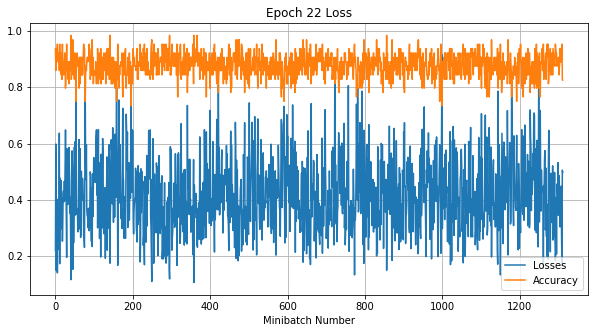

Phase train, Epoch 22, Overall Loss: 0.4176 and Accuracy: 0.8792
Phase val, Epoch 22, Overall Loss: 0.2774 and Accuracy: 0.9220
--------------
Starting epoch 23 / 40
t = 100, loss = 0.4635, acc = 0.8281
t = 200, loss = 0.5680, acc = 0.7969
t = 300, loss = 0.2519, acc = 0.9375
t = 400, loss = 0.3558, acc = 0.8750
t = 500, loss = 0.4966, acc = 0.8750
t = 600, loss = 0.3838, acc = 0.9062
t = 700, loss = 0.4305, acc = 0.8281
t = 800, loss = 0.3994, acc = 0.8594
t = 900, loss = 0.3270, acc = 0.8906
t = 1000, loss = 0.1456, acc = 0.9688
t = 1100, loss = 0.5589, acc = 0.8281
t = 1200, loss = 0.5706, acc = 0.8125
t = 1300, loss = 0.4108, acc = 0.8750


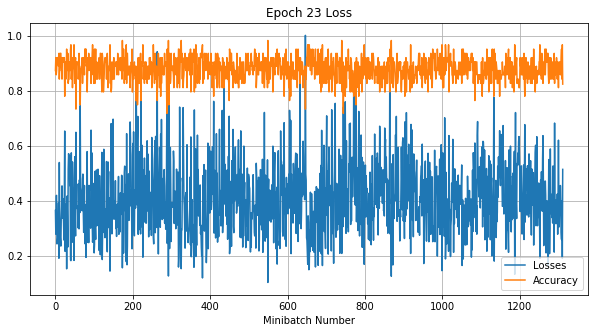

Phase train, Epoch 23, Overall Loss: 0.4104 and Accuracy: 0.8805
Phase val, Epoch 23, Overall Loss: 0.3293 and Accuracy: 0.9023
--------------
Starting epoch 24 / 40
t = 100, loss = 0.3380, acc = 0.9219
t = 200, loss = 0.3421, acc = 0.8750
t = 300, loss = 0.5065, acc = 0.8438
t = 400, loss = 0.3783, acc = 0.8906
t = 500, loss = 0.2409, acc = 0.9219
t = 600, loss = 0.3831, acc = 0.8906
t = 700, loss = 0.2772, acc = 0.9062
t = 800, loss = 0.2985, acc = 0.9375
t = 900, loss = 0.5557, acc = 0.8750
t = 1000, loss = 0.4415, acc = 0.8906
t = 1100, loss = 0.4407, acc = 0.8125
t = 1200, loss = 0.3821, acc = 0.8906
t = 1300, loss = 0.4734, acc = 0.8594


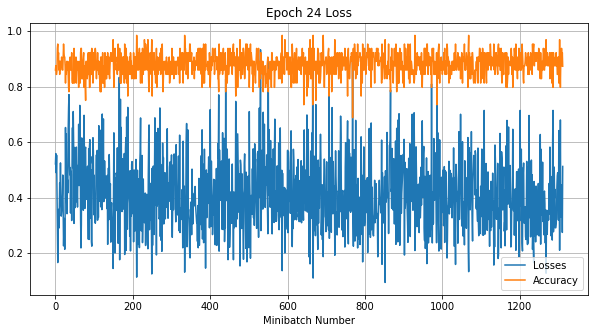

Phase train, Epoch 24, Overall Loss: 0.4133 and Accuracy: 0.8799
Phase val, Epoch 24, Overall Loss: 0.6295 and Accuracy: 0.8261
--------------
Starting epoch 25 / 40
t = 100, loss = 0.3020, acc = 0.9062
t = 200, loss = 0.2793, acc = 0.8906
t = 300, loss = 0.3012, acc = 0.9062
t = 400, loss = 0.5622, acc = 0.8281
t = 500, loss = 0.4507, acc = 0.8750
t = 600, loss = 0.3063, acc = 0.9062
t = 700, loss = 0.3513, acc = 0.9062
t = 800, loss = 0.5056, acc = 0.8125
t = 900, loss = 0.5336, acc = 0.8281
t = 1000, loss = 0.3354, acc = 0.8906
t = 1100, loss = 0.3788, acc = 0.8750
t = 1200, loss = 0.3673, acc = 0.9375
t = 1300, loss = 0.3672, acc = 0.8906


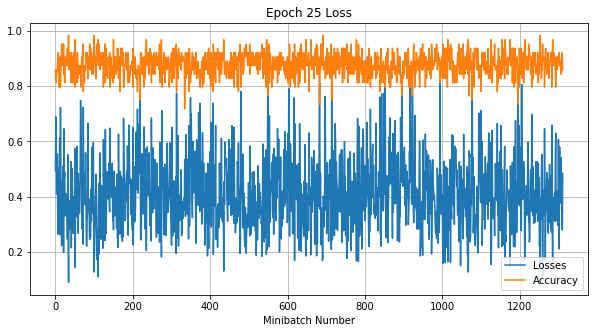

Phase train, Epoch 25, Overall Loss: 0.4114 and Accuracy: 0.8798
Phase val, Epoch 25, Overall Loss: 0.2796 and Accuracy: 0.9143
--------------
Starting epoch 26 / 40
t = 100, loss = 0.3243, acc = 0.8906
t = 200, loss = 0.6132, acc = 0.7969
t = 300, loss = 0.3498, acc = 0.8906
t = 400, loss = 0.3553, acc = 0.8750
t = 500, loss = 0.4984, acc = 0.8594
t = 600, loss = 0.3621, acc = 0.8750
t = 700, loss = 0.5886, acc = 0.8438
t = 800, loss = 0.2615, acc = 0.8906
t = 900, loss = 0.4945, acc = 0.9062
t = 1000, loss = 0.3908, acc = 0.8906
t = 1100, loss = 0.5341, acc = 0.8281
t = 1200, loss = 0.3012, acc = 0.9219
t = 1300, loss = 0.3042, acc = 0.9375


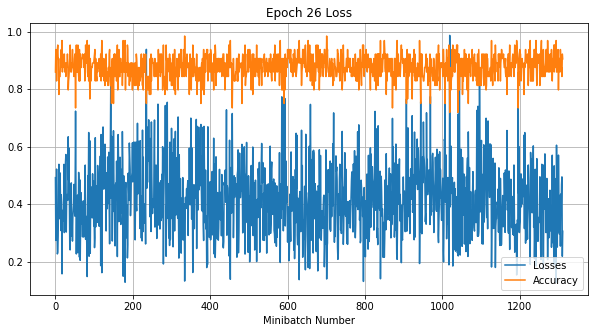

Phase train, Epoch 26, Overall Loss: 0.4195 and Accuracy: 0.8774
Phase val, Epoch 26, Overall Loss: 0.3059 and Accuracy: 0.9014
--------------
Starting epoch 27 / 40
t = 100, loss = 0.4559, acc = 0.8750
t = 200, loss = 0.5469, acc = 0.8281
t = 300, loss = 0.4656, acc = 0.8750
t = 400, loss = 0.4226, acc = 0.8906
t = 500, loss = 0.5356, acc = 0.8594
t = 600, loss = 0.4056, acc = 0.8750
t = 700, loss = 0.2041, acc = 0.9375
t = 800, loss = 0.2733, acc = 0.9375
t = 900, loss = 0.2662, acc = 0.9531
t = 1000, loss = 0.4566, acc = 0.8438
t = 1100, loss = 0.2760, acc = 0.9375
t = 1200, loss = 0.3941, acc = 0.8906
t = 1300, loss = 0.5233, acc = 0.8594


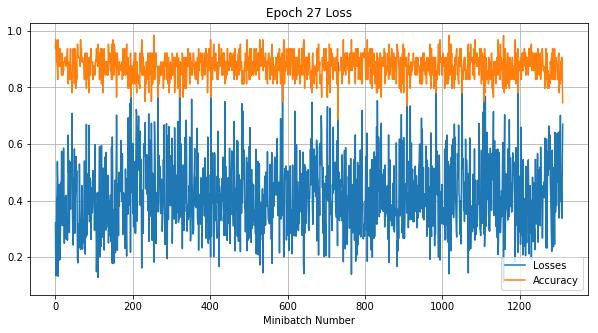

Phase train, Epoch 27, Overall Loss: 0.4191 and Accuracy: 0.8765
Phase val, Epoch 27, Overall Loss: 0.7926 and Accuracy: 0.7971
--------------
Starting epoch 28 / 40
t = 100, loss = 0.3859, acc = 0.8750
t = 200, loss = 0.2163, acc = 0.9531
t = 300, loss = 0.4752, acc = 0.8750
t = 400, loss = 0.4457, acc = 0.8906
t = 500, loss = 0.3518, acc = 0.9062
t = 600, loss = 0.3897, acc = 0.8594
t = 700, loss = 0.2741, acc = 0.9219
t = 800, loss = 0.6998, acc = 0.7344
t = 900, loss = 0.5366, acc = 0.8906
t = 1000, loss = 0.4782, acc = 0.8281
t = 1100, loss = 0.4676, acc = 0.8906
t = 1200, loss = 0.3213, acc = 0.9219
t = 1300, loss = 0.3689, acc = 0.9062


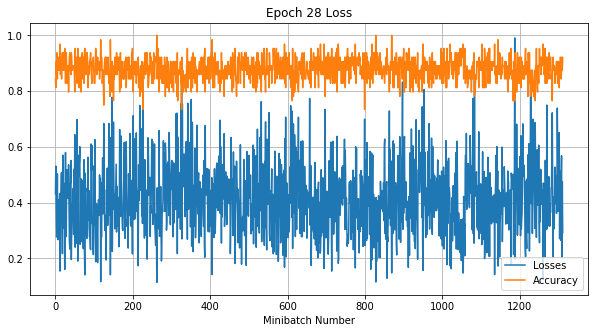

Phase train, Epoch 28, Overall Loss: 0.4133 and Accuracy: 0.8791
Phase val, Epoch 28, Overall Loss: 0.7460 and Accuracy: 0.7959
--------------
Starting epoch 29 / 40
t = 100, loss = 0.8562, acc = 0.7500
t = 200, loss = 0.3806, acc = 0.8906
t = 300, loss = 0.6313, acc = 0.8438
t = 400, loss = 0.8296, acc = 0.8281
t = 500, loss = 0.4738, acc = 0.8594
t = 600, loss = 0.2131, acc = 0.9531
t = 700, loss = 0.4599, acc = 0.8906
t = 800, loss = 0.4931, acc = 0.8750
t = 900, loss = 0.4050, acc = 0.8906
t = 1000, loss = 0.3230, acc = 0.9219
t = 1100, loss = 0.2363, acc = 0.8906
t = 1200, loss = 0.2656, acc = 0.9062
t = 1300, loss = 0.2148, acc = 0.9219


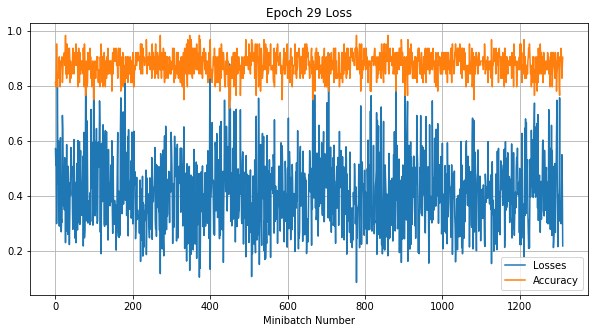

Phase train, Epoch 29, Overall Loss: 0.4116 and Accuracy: 0.8794
Phase val, Epoch 29, Overall Loss: 0.2225 and Accuracy: 0.9392
--------------
Starting epoch 30 / 40
t = 100, loss = 0.3275, acc = 0.8906
t = 200, loss = 0.2045, acc = 0.9688
t = 300, loss = 0.4086, acc = 0.8906
t = 400, loss = 0.7974, acc = 0.7969
t = 500, loss = 0.4250, acc = 0.8906
t = 600, loss = 0.4614, acc = 0.8750
t = 700, loss = 0.5026, acc = 0.8438
t = 800, loss = 0.3044, acc = 0.8750
t = 900, loss = 0.3761, acc = 0.8906
t = 1000, loss = 0.3645, acc = 0.9062
t = 1100, loss = 0.3789, acc = 0.9062
t = 1200, loss = 0.3979, acc = 0.9219
t = 1300, loss = 0.3622, acc = 0.9062


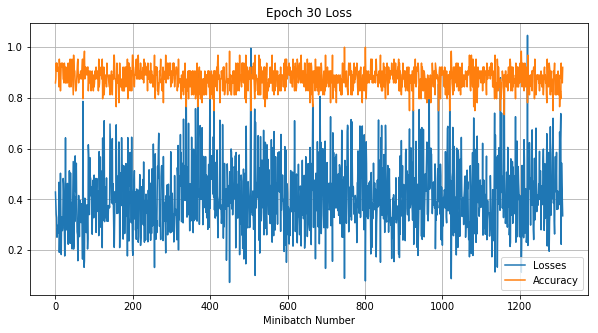

Phase train, Epoch 30, Overall Loss: 0.4150 and Accuracy: 0.8790
Phase val, Epoch 30, Overall Loss: 0.3880 and Accuracy: 0.8812
--------------
Starting epoch 31 / 40
t = 100, loss = 0.5241, acc = 0.8125
t = 200, loss = 0.1647, acc = 0.9531
t = 300, loss = 0.3570, acc = 0.9219
t = 400, loss = 0.6121, acc = 0.8281
t = 500, loss = 0.3419, acc = 0.9219
t = 600, loss = 0.6428, acc = 0.7969
t = 700, loss = 0.5999, acc = 0.7969
t = 800, loss = 0.3518, acc = 0.9062
t = 900, loss = 0.4022, acc = 0.8906
t = 1000, loss = 0.2799, acc = 0.9219
t = 1100, loss = 0.5733, acc = 0.8594
t = 1200, loss = 0.4013, acc = 0.8906
t = 1300, loss = 0.5545, acc = 0.8125


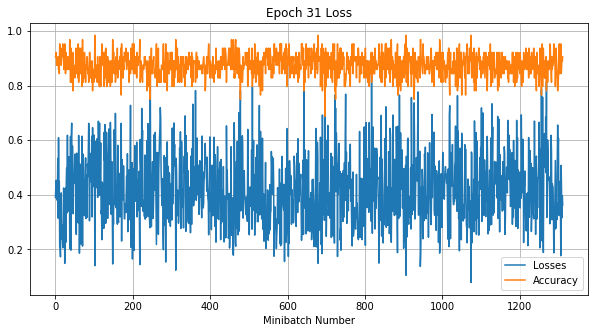

Phase train, Epoch 31, Overall Loss: 0.4214 and Accuracy: 0.8765
Phase val, Epoch 31, Overall Loss: 0.4569 and Accuracy: 0.8694
--------------
Starting epoch 32 / 40
t = 100, loss = 0.6670, acc = 0.8750
t = 200, loss = 0.5274, acc = 0.8594
t = 300, loss = 0.2464, acc = 0.9062
t = 400, loss = 0.3283, acc = 0.8750
t = 500, loss = 0.2029, acc = 0.9375
t = 600, loss = 0.2989, acc = 0.9062
t = 700, loss = 0.3273, acc = 0.8750
t = 800, loss = 0.7746, acc = 0.7656
t = 900, loss = 0.5587, acc = 0.8281
t = 1000, loss = 0.3709, acc = 0.9062
t = 1100, loss = 0.4521, acc = 0.8594
t = 1200, loss = 0.4770, acc = 0.8594
t = 1300, loss = 0.2476, acc = 0.9219


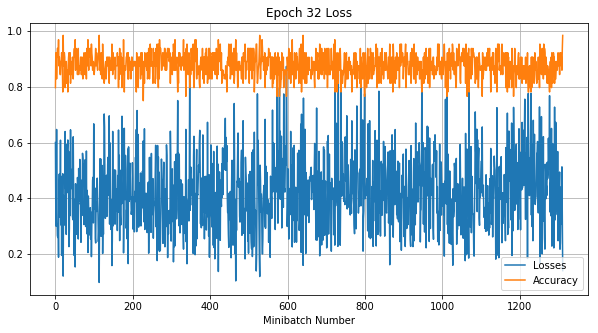

Phase train, Epoch 32, Overall Loss: 0.4189 and Accuracy: 0.8777
Phase val, Epoch 32, Overall Loss: 0.4509 and Accuracy: 0.8481
--------------
Starting epoch 33 / 40
t = 100, loss = 0.4183, acc = 0.8906
t = 200, loss = 0.6117, acc = 0.8438
t = 300, loss = 0.4608, acc = 0.8750
t = 400, loss = 0.4549, acc = 0.8594
t = 500, loss = 0.3561, acc = 0.9062
t = 600, loss = 0.5696, acc = 0.7969
t = 700, loss = 0.5877, acc = 0.8281
t = 800, loss = 0.2712, acc = 0.9062
t = 900, loss = 0.4853, acc = 0.8438
t = 1000, loss = 0.4686, acc = 0.8125
t = 1100, loss = 0.5329, acc = 0.8438
t = 1200, loss = 0.2870, acc = 0.9219
t = 1300, loss = 0.7382, acc = 0.7656


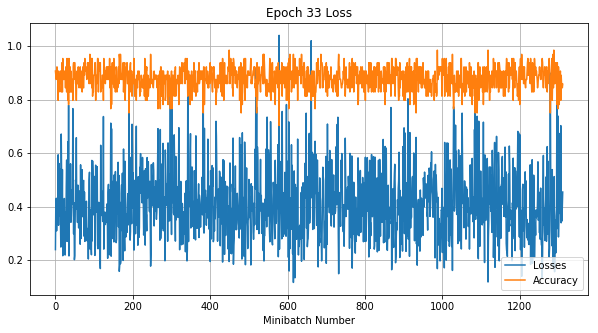

Phase train, Epoch 33, Overall Loss: 0.4123 and Accuracy: 0.8791
Phase val, Epoch 33, Overall Loss: 0.2624 and Accuracy: 0.9193
--------------
Starting epoch 34 / 40
t = 100, loss = 0.4812, acc = 0.8906
t = 200, loss = 0.3725, acc = 0.8906
t = 300, loss = 0.2910, acc = 0.9375
t = 400, loss = 0.3347, acc = 0.8906
t = 500, loss = 0.6258, acc = 0.8438
t = 600, loss = 0.3527, acc = 0.9219
t = 700, loss = 0.2955, acc = 0.9062
t = 800, loss = 0.3470, acc = 0.9219
t = 900, loss = 0.3938, acc = 0.8906
t = 1000, loss = 0.4914, acc = 0.8438
t = 1100, loss = 0.4227, acc = 0.8594
t = 1200, loss = 0.4766, acc = 0.8594
t = 1300, loss = 0.2461, acc = 0.9375


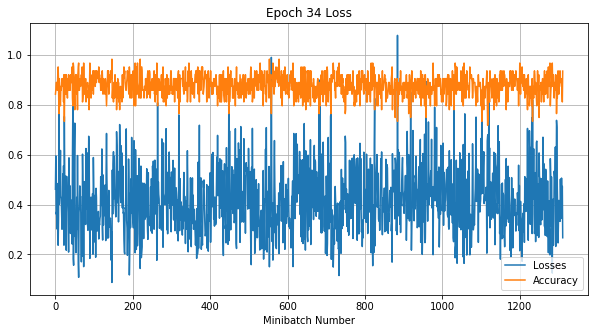

Phase train, Epoch 34, Overall Loss: 0.4180 and Accuracy: 0.8778
Phase val, Epoch 34, Overall Loss: 0.3751 and Accuracy: 0.8948
--------------
Starting epoch 35 / 40
t = 100, loss = 0.5264, acc = 0.8438
t = 200, loss = 0.4011, acc = 0.9062
t = 300, loss = 0.4561, acc = 0.8281
t = 400, loss = 0.3336, acc = 0.8750
t = 500, loss = 0.5511, acc = 0.8438
t = 600, loss = 0.4791, acc = 0.8750
t = 700, loss = 0.3042, acc = 0.8906
t = 800, loss = 0.3910, acc = 0.9062
t = 900, loss = 0.5062, acc = 0.8750
t = 1000, loss = 0.2484, acc = 0.9062
t = 1100, loss = 0.3417, acc = 0.9219
t = 1200, loss = 0.4670, acc = 0.8750
t = 1300, loss = 0.3734, acc = 0.8906


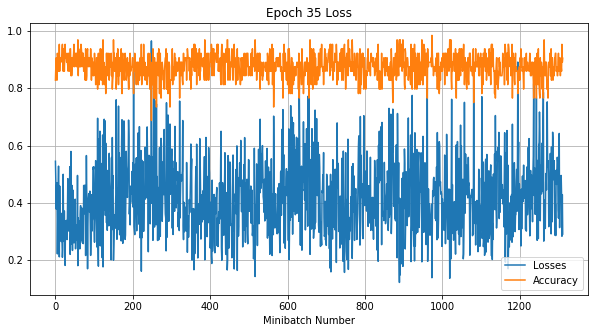

Phase train, Epoch 35, Overall Loss: 0.4183 and Accuracy: 0.8768
Phase val, Epoch 35, Overall Loss: 0.4552 and Accuracy: 0.8726
--------------
Starting epoch 36 / 40
t = 100, loss = 0.3676, acc = 0.9062
t = 200, loss = 0.4992, acc = 0.8594
t = 300, loss = 0.3291, acc = 0.8906
t = 400, loss = 0.3361, acc = 0.9062
t = 500, loss = 0.4854, acc = 0.8438
t = 600, loss = 0.1772, acc = 0.9375
t = 700, loss = 0.5313, acc = 0.8594
t = 800, loss = 0.3713, acc = 0.8750
t = 900, loss = 0.5524, acc = 0.8750
t = 1000, loss = 0.3620, acc = 0.9062
t = 1100, loss = 0.4903, acc = 0.8750
t = 1200, loss = 0.3235, acc = 0.9219
t = 1300, loss = 0.3946, acc = 0.9219


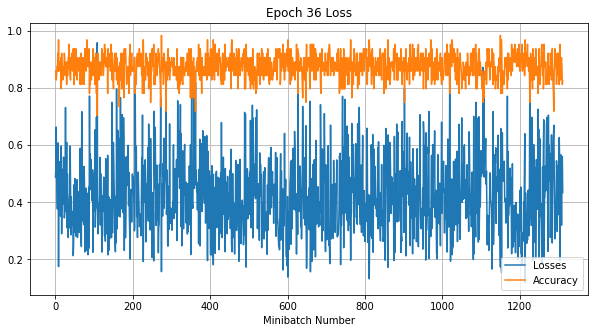

Phase train, Epoch 36, Overall Loss: 0.4242 and Accuracy: 0.8760
Phase val, Epoch 36, Overall Loss: 0.4042 and Accuracy: 0.8785
--------------
Starting epoch 37 / 40
t = 100, loss = 0.3355, acc = 0.9062
t = 200, loss = 0.3773, acc = 0.8906
t = 300, loss = 0.2931, acc = 0.8906
t = 400, loss = 0.5621, acc = 0.8594
t = 500, loss = 0.4473, acc = 0.8281
t = 600, loss = 0.3283, acc = 0.9062
t = 700, loss = 0.3407, acc = 0.8906
t = 800, loss = 0.5085, acc = 0.8750
t = 900, loss = 0.2241, acc = 0.9375
t = 1000, loss = 0.4181, acc = 0.8594
t = 1100, loss = 0.2596, acc = 0.9219
t = 1200, loss = 0.4798, acc = 0.8281
t = 1300, loss = 0.4098, acc = 0.8906


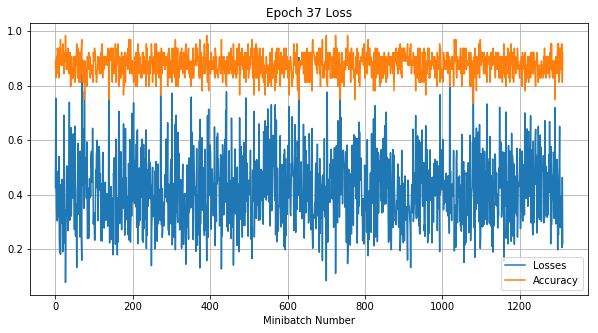

Phase train, Epoch 37, Overall Loss: 0.4180 and Accuracy: 0.8779
Phase val, Epoch 37, Overall Loss: 0.1529 and Accuracy: 0.9503
--------------
Starting epoch 38 / 40
t = 100, loss = 0.4306, acc = 0.8750
t = 200, loss = 0.5123, acc = 0.8750
t = 300, loss = 0.3810, acc = 0.8906
t = 400, loss = 0.2604, acc = 0.9375
t = 500, loss = 0.3198, acc = 0.9062
t = 600, loss = 0.5148, acc = 0.8438
t = 700, loss = 0.2008, acc = 0.9375
t = 800, loss = 0.5403, acc = 0.8125
t = 900, loss = 0.5551, acc = 0.8594
t = 1000, loss = 0.3641, acc = 0.8906
t = 1100, loss = 0.4188, acc = 0.8750
t = 1200, loss = 0.6779, acc = 0.8125
t = 1300, loss = 0.4816, acc = 0.8438


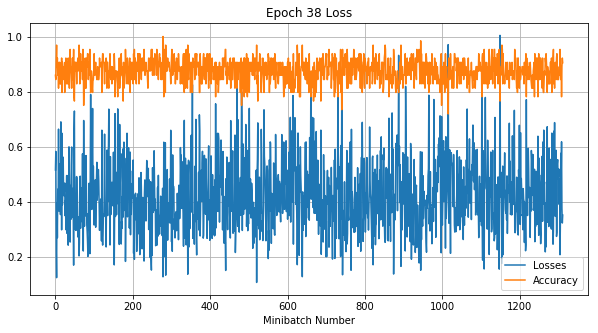

Phase train, Epoch 38, Overall Loss: 0.4224 and Accuracy: 0.8763
Phase val, Epoch 38, Overall Loss: 0.2047 and Accuracy: 0.9408
--------------
Starting epoch 39 / 40
t = 100, loss = 0.4055, acc = 0.9219
t = 200, loss = 0.5035, acc = 0.8594
t = 300, loss = 0.4555, acc = 0.8906
t = 400, loss = 0.8141, acc = 0.8125
t = 500, loss = 0.6210, acc = 0.8438
t = 600, loss = 0.3274, acc = 0.9375
t = 700, loss = 0.3283, acc = 0.9219
t = 800, loss = 0.5256, acc = 0.8594
t = 900, loss = 0.6277, acc = 0.8281
t = 1000, loss = 0.4366, acc = 0.8594
t = 1100, loss = 0.2611, acc = 0.9375
t = 1200, loss = 0.3434, acc = 0.8750
t = 1300, loss = 0.4487, acc = 0.8906


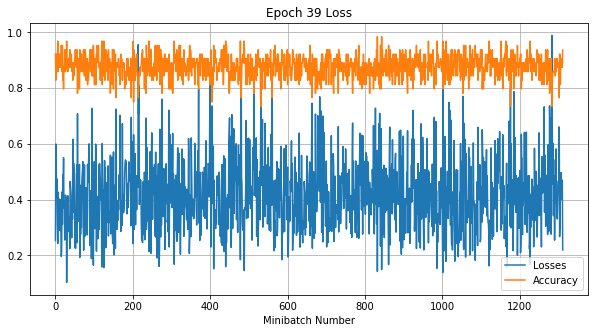

Phase train, Epoch 39, Overall Loss: 0.4167 and Accuracy: 0.8782
Phase val, Epoch 39, Overall Loss: 0.5862 and Accuracy: 0.8025
--------------
Starting epoch 40 / 40
t = 100, loss = 0.6885, acc = 0.7656
t = 200, loss = 0.4296, acc = 0.8594
t = 300, loss = 0.2506, acc = 0.9375
t = 400, loss = 0.5129, acc = 0.8594
t = 500, loss = 0.3511, acc = 0.8750
t = 600, loss = 0.2435, acc = 0.9219
t = 700, loss = 0.5585, acc = 0.8438
t = 800, loss = 0.4336, acc = 0.8438
t = 900, loss = 0.3936, acc = 0.9062
t = 1000, loss = 0.5400, acc = 0.8594
t = 1100, loss = 0.3472, acc = 0.8906
t = 1200, loss = 0.5495, acc = 0.8281
t = 1300, loss = 0.5769, acc = 0.8750


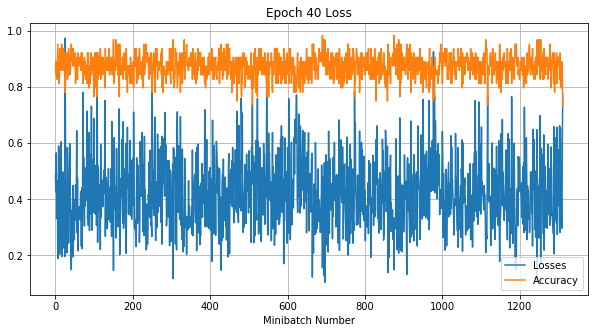

Phase train, Epoch 40, Overall Loss: 0.4230 and Accuracy: 0.8745
Phase val, Epoch 40, Overall Loss: 0.4310 and Accuracy: 0.8834


In [66]:
mobile_net = MobileNet().cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobile_net.parameters(), lr=0.1, momentum=0.9, dampening=0, weight_decay=0.0005, nesterov=True)
best_mobile_net = train(mobile_net, loss_fn, optimizer, num_epochs=40)

## 5. Evaluate Model on Test Set

After finishing the training phase, I feed the test images and labels to evaluate the best-so-far model state.

In [75]:
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval() 
    for x, y in loader:
        x_var = Variable(x.float().cuda(), volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

Despite having much larger training and validation accuracy, given the amount of training epoches, my model achieves the baseline of 93%. Obviously, this can be improved for larger number of training epoches. 

In [76]:
check_accuracy(best_lenet, loader_test)

Got 11748 / 12630 correct (93.02)


In [77]:
check_accuracy(best_mobile_net, loader_test)

Got 11859 / 12630 correct (93.90)


## 6. Evaluate Model on New Images

I downloaded 20 images from the internet. Similar to @eqbal. For every image, I resize it to (32x32) to fit the trained model.

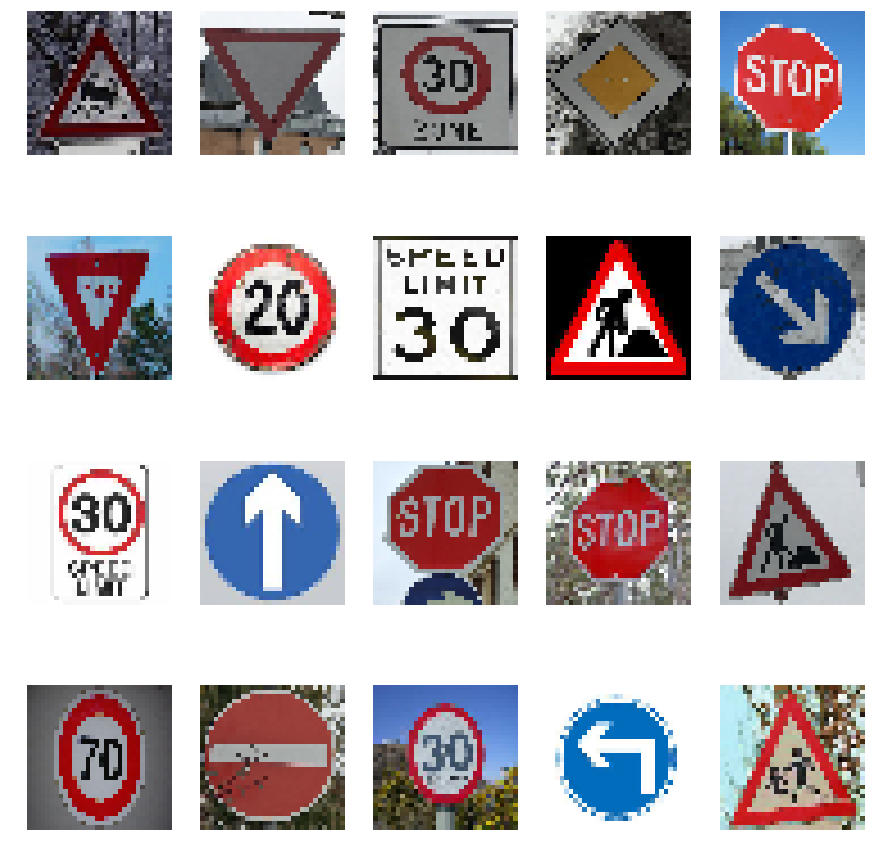

In [67]:
import os
test_images = []
path = "dataset/test_images/"
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_images.append(img)

plt.figure(figsize=(15, 20))
for i, image in enumerate(test_images):
    grid = plt.subplot(len(test_images)/4,5,i+1)
    grid.imshow(image), plt.axis('off')
    
plt.show()

In [68]:
test_tensors = torch.from_numpy(np.transpose(np.asarray(test_images), (0,3,1,2))).float() / 255.0

def predict_and_visualize(net, test_tensors):
    net.eval()
    outputs = net(Variable(test_tensors.cuda(), volatile=True))
    _, predicted = torch.max(outputs.data.cpu(), 1)
    outputclass = predicted.numpy()
    plt.figure(figsize=(15,20))
    for i, image in enumerate(test_images):
        grid = plt.subplot(len(test_images)/4,5,i+1)
        grid.imshow(image), plt.axis('off')
        plt.title(sign_names[outputclass[i]])
    plt.show()
    return outputs

### a. LeNet

For each image, I output the top guess and they turn out pretty okay.

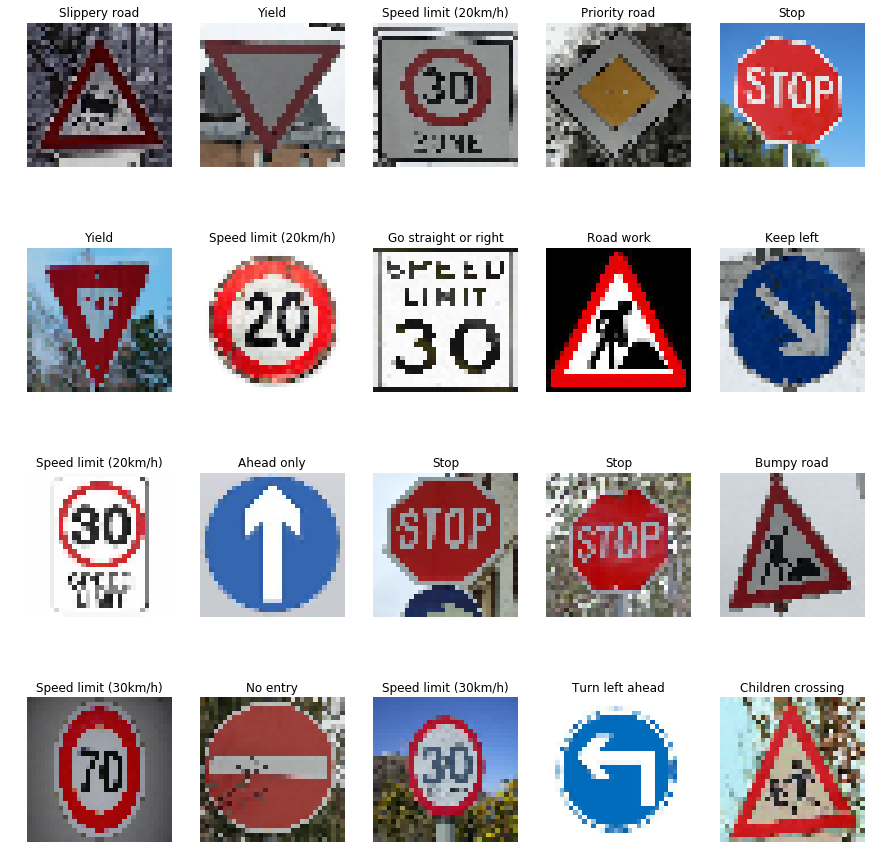

In [104]:
lenet_outputs = predict_and_visualize(best_lenet, test_tensors)

I also output the top-5 "guesses" that have the largest softmax probabilities. These are shown in the histogram below.

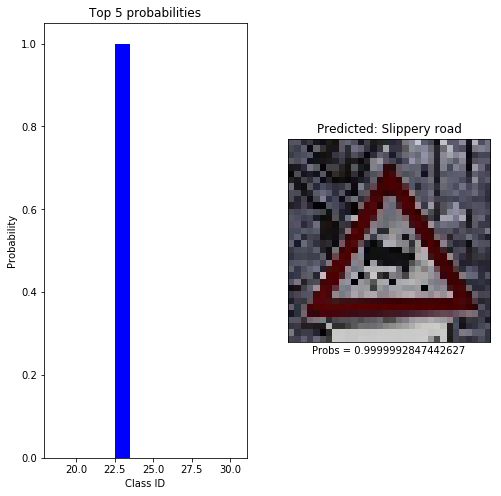

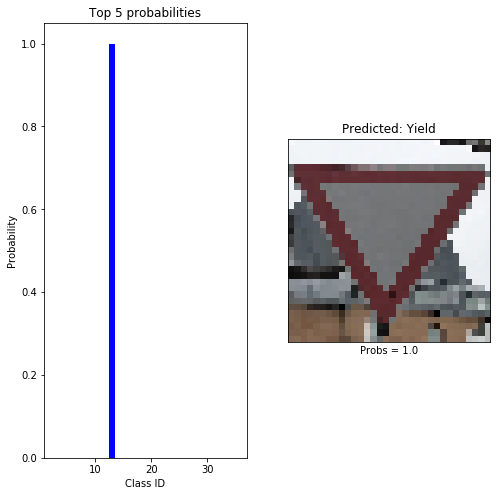

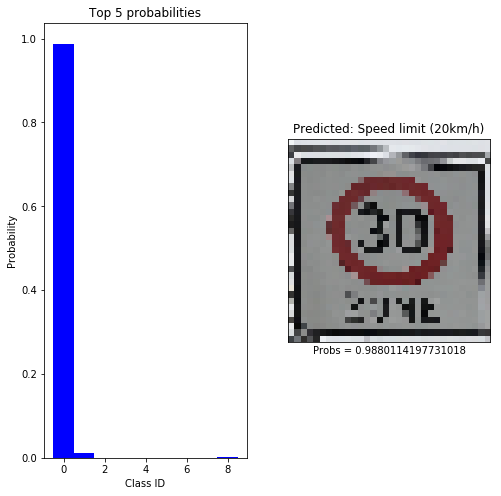

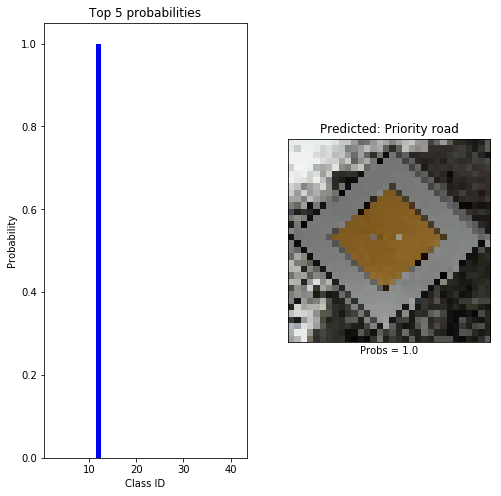

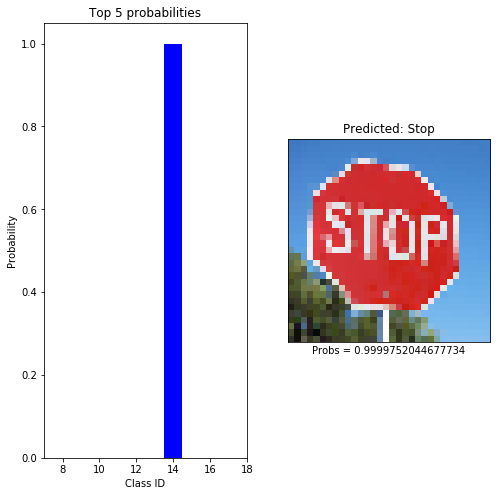

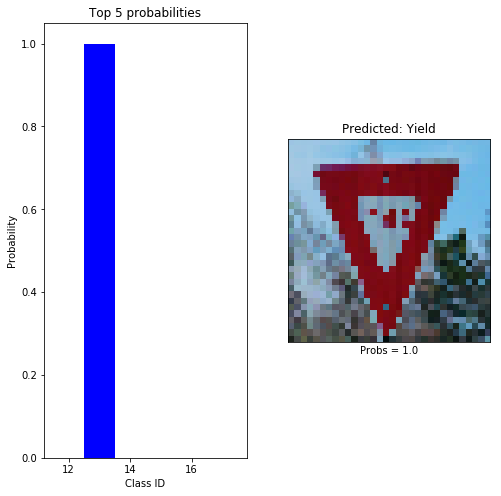

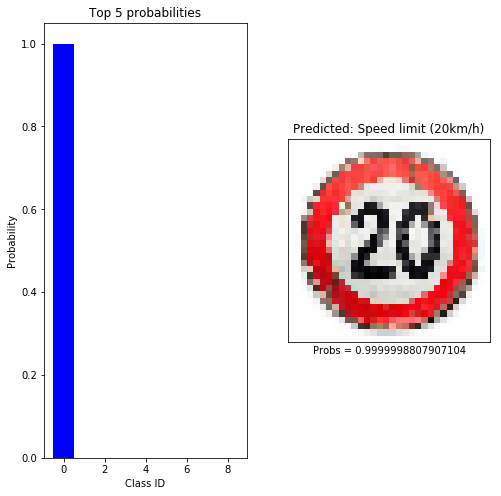

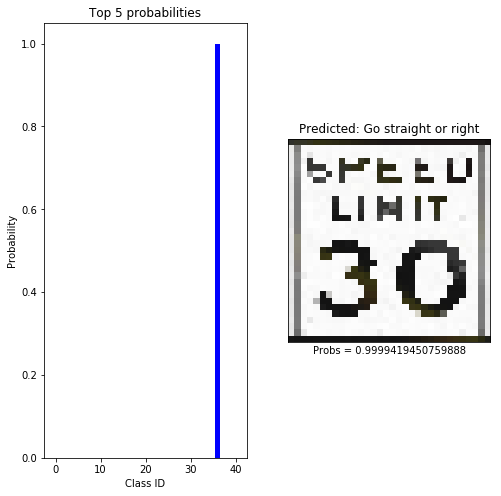

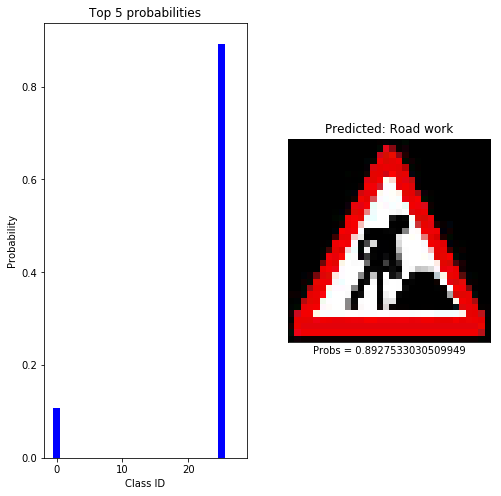

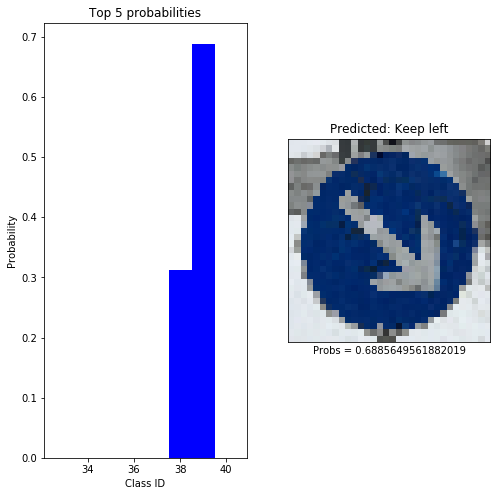

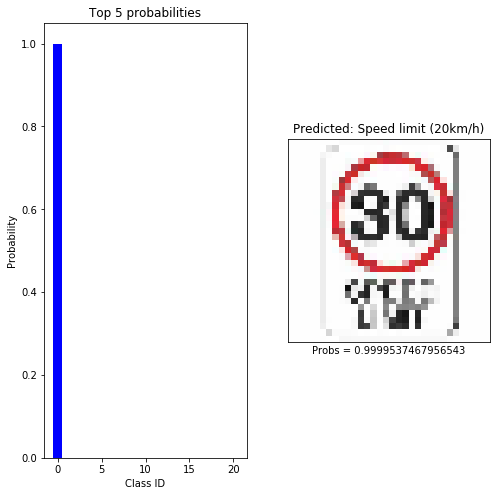

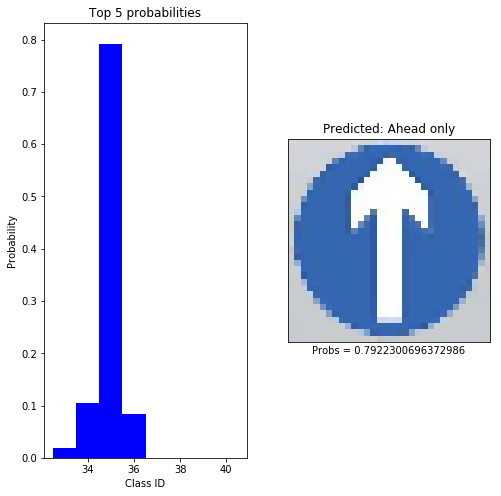

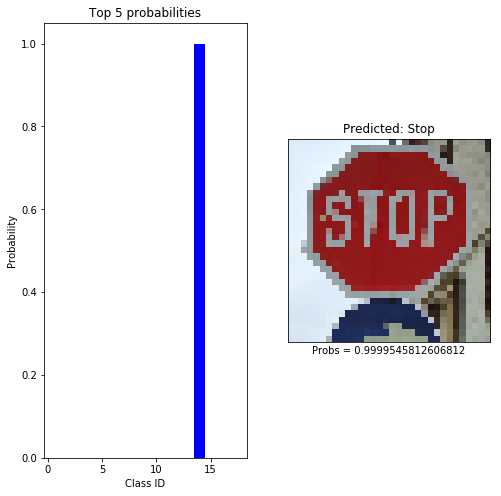

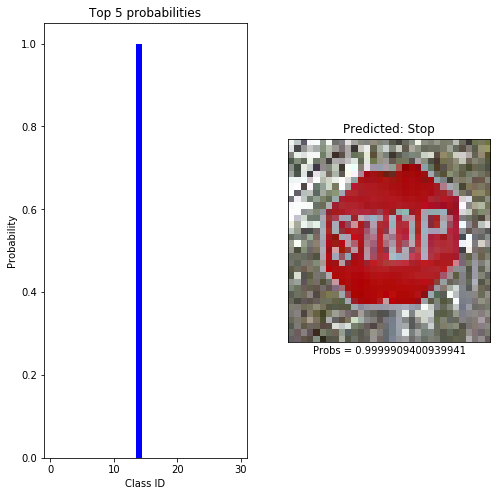

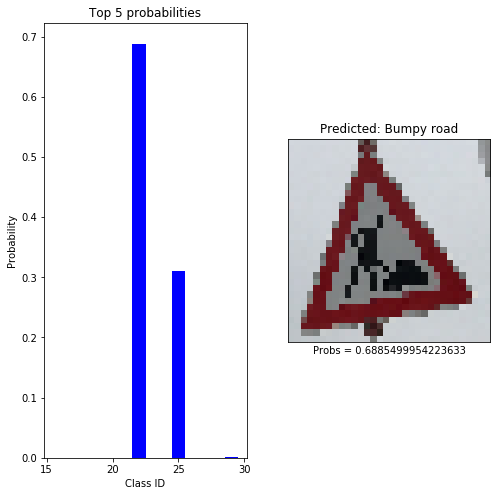

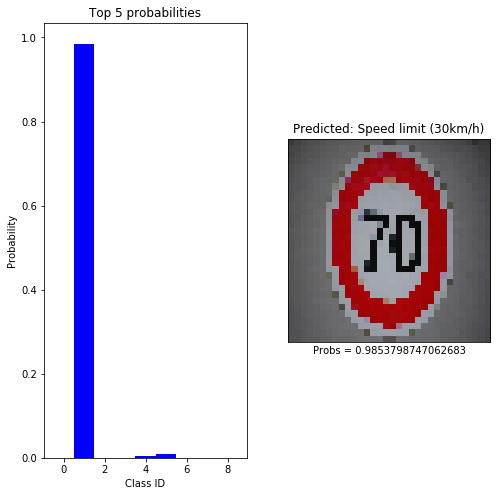

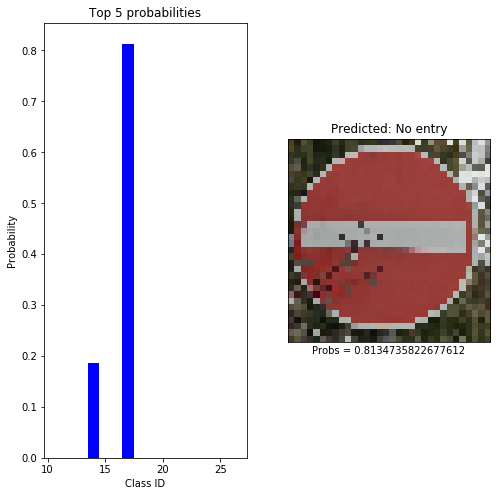

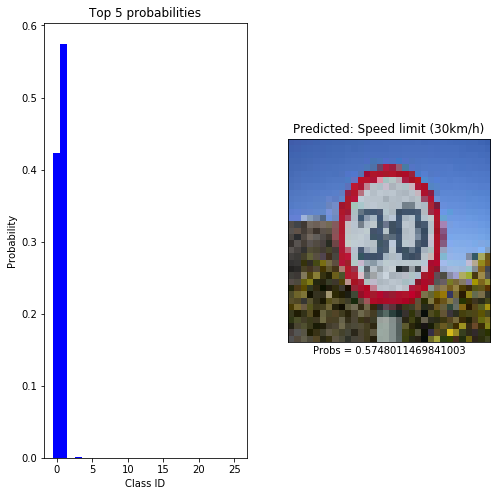

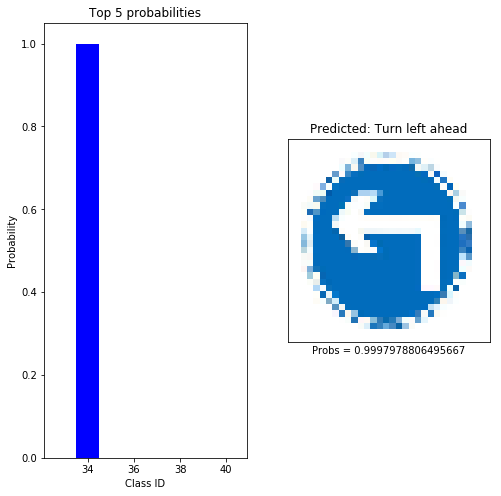

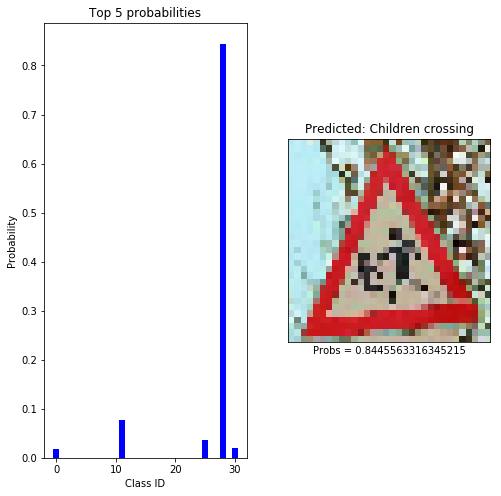

In [105]:
probs = F.softmax(lenet_outputs, dim=1)
top_K_values, top_K_indices = torch.topk(probs.data.cpu(), dim=1, k=5)
top_K_values, top_K_indices = top_K_values.numpy(), top_K_indices.numpy()

def plot_probability_per_class(probabilities, classes, image):  
    """ For each image, input top-k probabilities, classes and visualize them. Source: @eqbal.
    """
    mpl_fig = plt.figure(figsize=(8,8))
    ax = mpl_fig.add_subplot(121)
    ax.set_ylabel('Probability')
    ax.set_xlabel('Class ID')
    ax.set_title('Top 5 probabilities')
    ax.bar(classes, probabilities, 1, color='blue', label='Inputs per class')
    
    top = probabilities.argmax()
    class_id = classes[top]
    
    ax = mpl_fig.add_subplot(122)
    ax.set_xticks([])
    ax.set_yticks([])
    title = "Predicted: %s" % sign_names[class_id]
    ax.set_title(title)
    ax.set_xlabel("Probs = {}".format(probabilities[top]))
    ax.imshow(image)

    plt.show()
    
for p, c, i in zip(top_K_values, top_K_indices, test_images):
    plot_probability_per_class(p, c, i)

### b. MobileNet

I did the same thing for the best MobileNet I got after training for 40 epoches. The results are pretty much the same. 

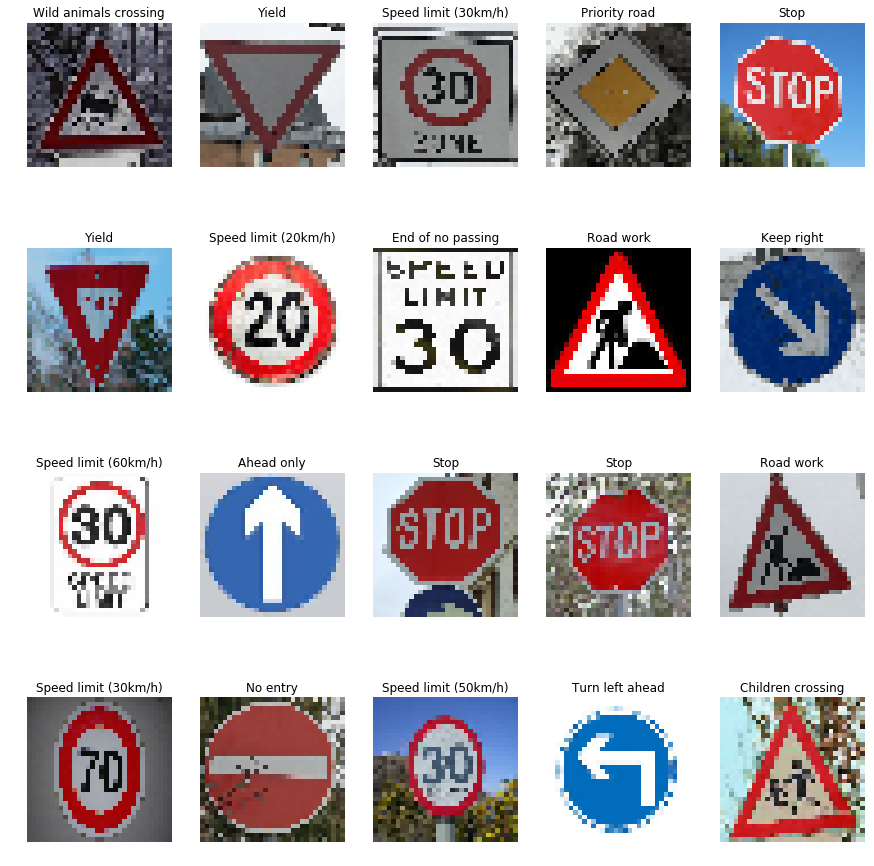

In [71]:
mobilenet_outputs = predict_and_visualize(best_mobile_net, test_tensors)

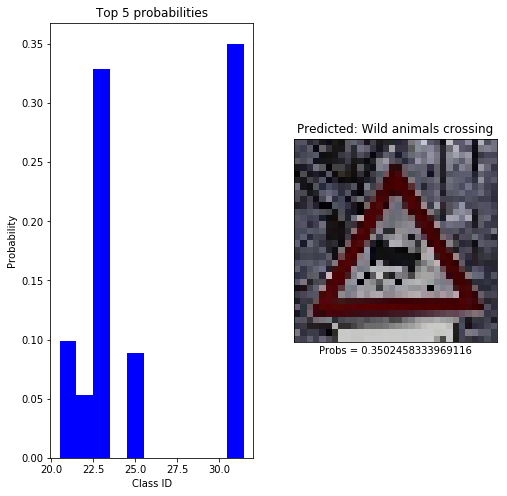

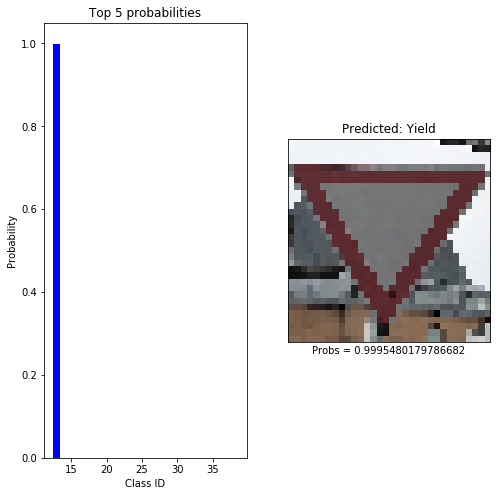

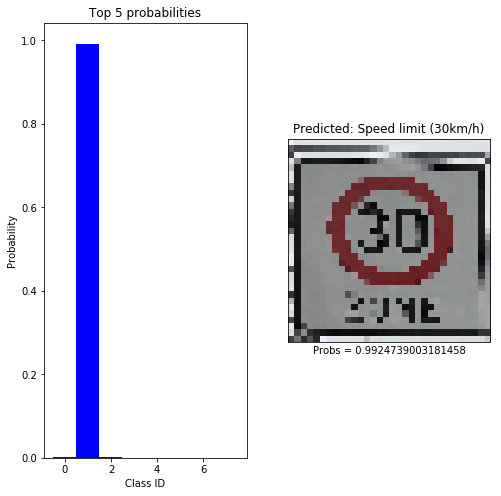

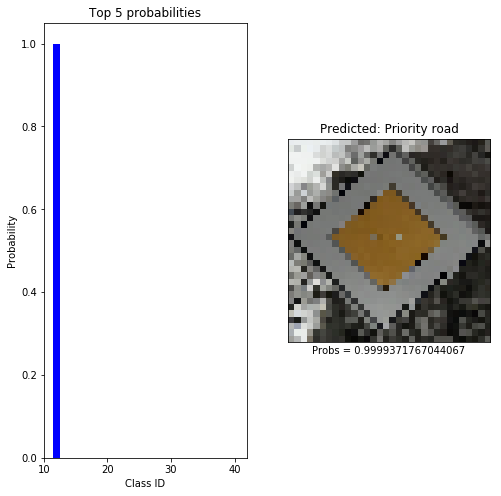

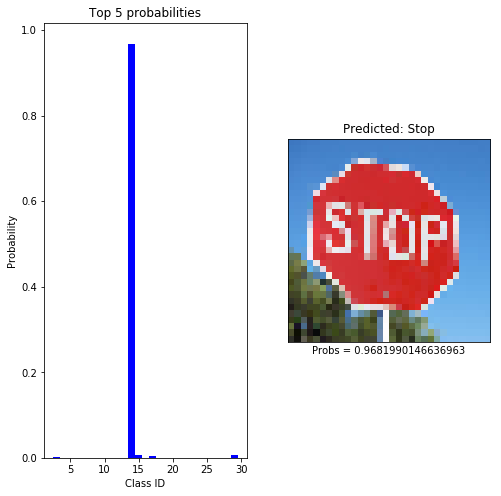

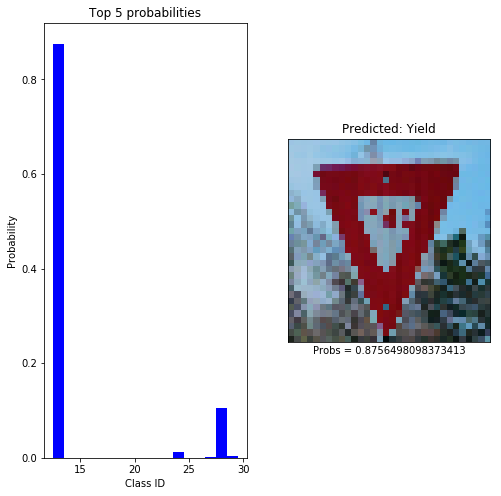

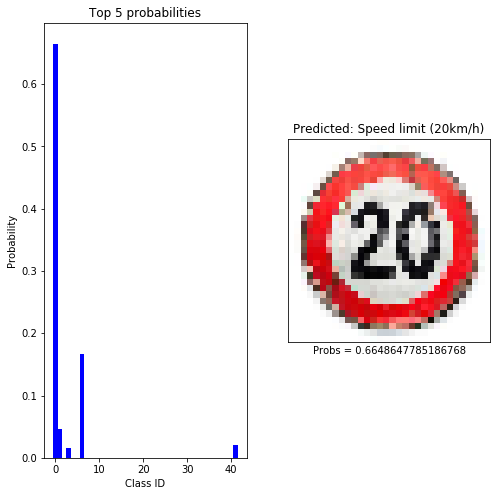

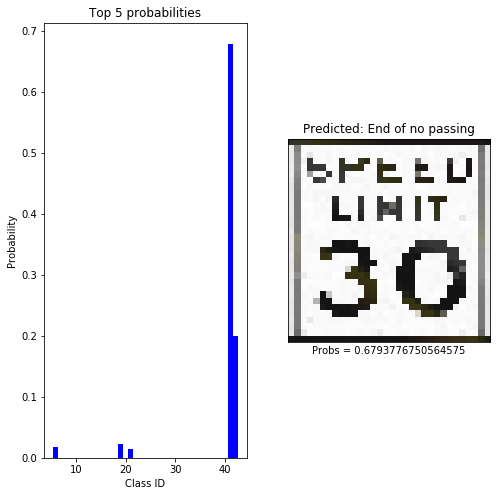

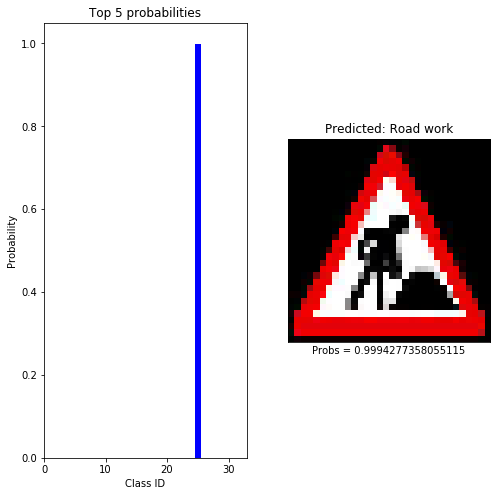

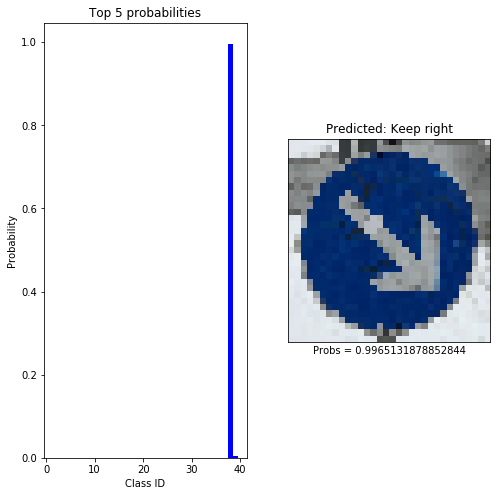

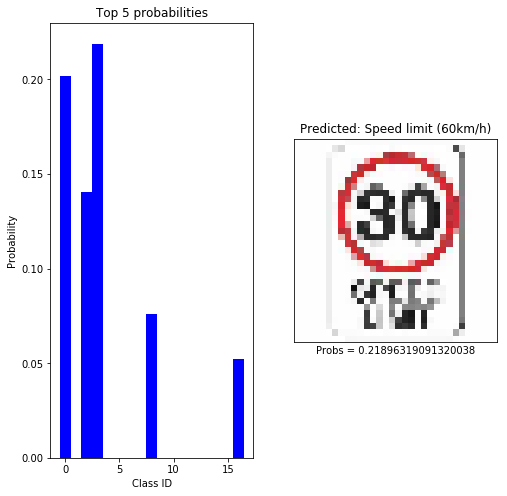

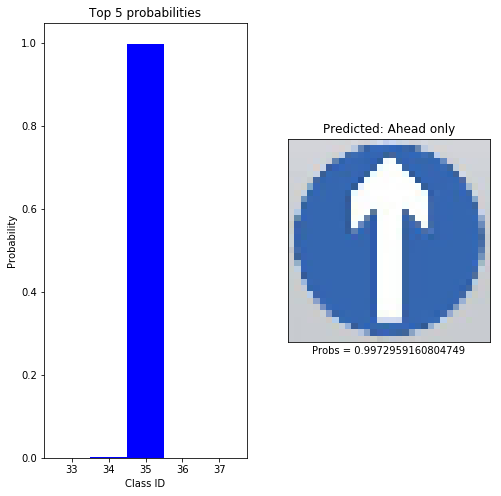

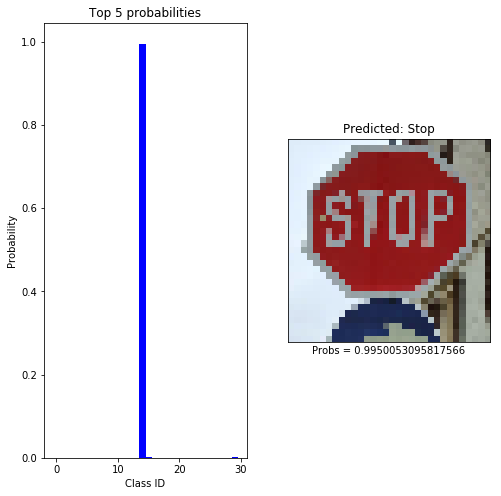

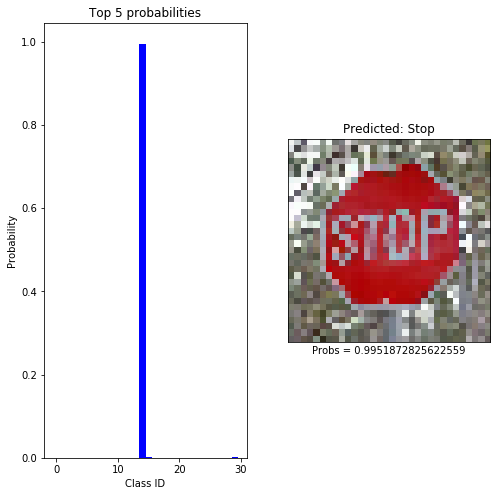

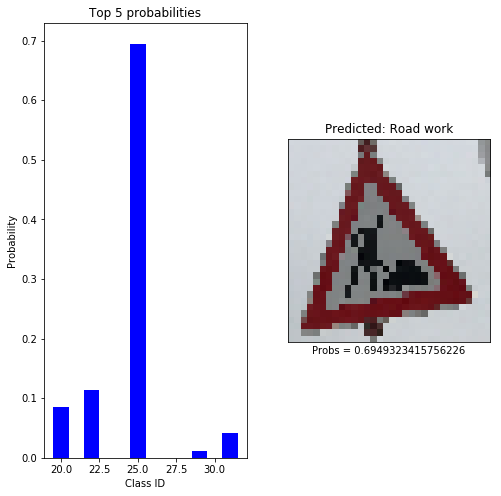

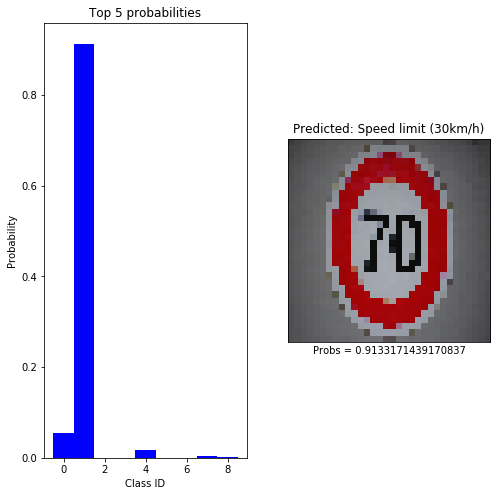

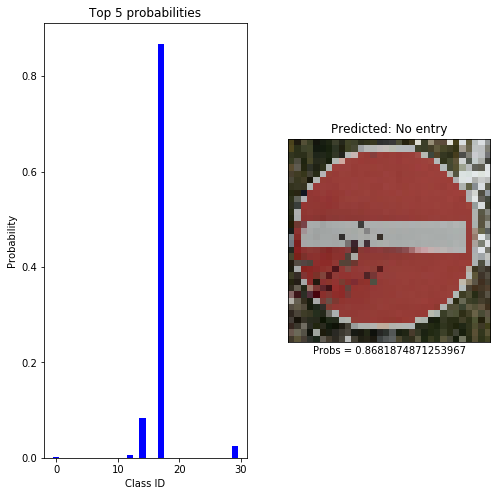

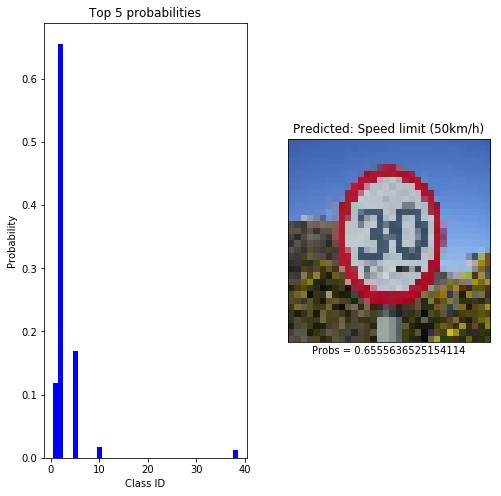

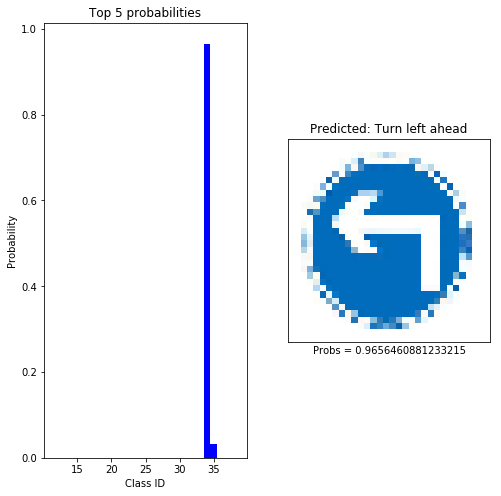

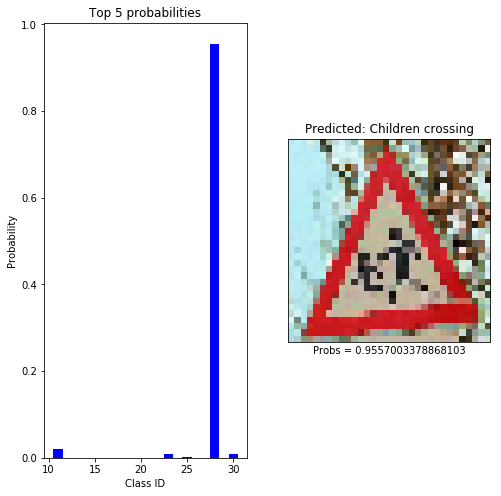

In [72]:
probs = F.softmax(mobilenet_outputs, dim=1)
top_K_values, top_K_indices = torch.topk(probs.data.cpu(), dim=1, k=5)
top_K_values, top_K_indices = top_K_values.numpy(), top_K_indices.numpy()

def plot_probability_per_class(probabilities, classes, image):  
    """ For each image, input top-k probabilities, classes and visualize them. Source: @eqbal.
    """
    mpl_fig = plt.figure(figsize=(8,8))
    ax = mpl_fig.add_subplot(121)
    ax.set_ylabel('Probability')
    ax.set_xlabel('Class ID')
    ax.set_title('Top 5 probabilities')
    ax.bar(classes, probabilities, 1, color='blue', label='Inputs per class')
    
    top = probabilities.argmax()
    class_id = classes[top]
    
    ax = mpl_fig.add_subplot(122)
    ax.set_xticks([])
    ax.set_yticks([])
    title = "Predicted: %s" % sign_names[class_id]
    ax.set_title(title)
    ax.set_xlabel("Probs = {}".format(probabilities[top]))
    ax.imshow(image)

    plt.show()
    
for p, c, i in zip(top_K_values, top_K_indices, test_images):
    plot_probability_per_class(p, c, i)